# Critical Scale Invariance in Healthy Human Heart Rate

#### Alessandro Casalino (2015122)
#### Michele M. Crudele (2021858) 
#### Babak Pornour Mehravani (1223582)
#### Daniele Mellino (2013373)

# Table of contents

1. [Introduction](#introduction)
2. [Imported libraries](#imported_libraries)
3. [Global variables](#global_variables)
4. [Signal processing functions](#signal_processing_functions)
    1. [Signal preprocessing](#preproc)
    2. [Cleaning of Interbeat intervals 𝑏](#clean_b_i)
    3. [The XQRS Algorithm](#xqrs_algorithm)
    4. [Signal plot with the detected QRS peaks](#qrs_plot)
    5. [Peaks correction example](#peaks_correction)
5. [Computation of interbeats 𝑏 from record](#b_computation_rec)
6. [Signal detrending and standardization](#detr_and_stand)
7. [Dataset class](#dataset_class)
    1. [Instantiating Dataset classes](#class_instantiating)
    2. [Computing and saving interbeat intervals 𝑏 and $Δ_𝑠𝐵$](#b_computing)
    3. [Loading interbeat intervals 𝑏 and standardized $Δ_𝑠𝐵$](#b_loading)
8. [The peaks distance problem](#peaks_distance_problem)
    1. [Plotting interbeat intervals 𝑏 before and after cleaning up](#plotting_b_before_after_cleaning)
    2. [Plotting signal from patient 16272](#patient_16272)
9. [Fit and data analysis](#fit_and_data_analysis)
    1. [Gaussian fit](#gauss)
        1. [Gaussian fit for Fantasia dataset](#gauss_fantasia)
        2. [Gaussian fit for MIT dataset](#gauss_mit)
    2. [Castaing fit](#castaing)
        1. [Castaing fit for Fantasia dataset](#castaing_fantasia)
        2. [Castaing fit for MIT dataset](#castaing_mit)
    3. [Dependence of fitting parameter $\lambda^2$ on the scale 𝑠 for Fantasia dataset and MIT dataset](#lambda_dependence)
    4. [Collapse Plot](#collapse)
        1. [Collapse Plot for Fantasia dataset](#collapse_fantasia)
        2. [Collapse Plot for MIT dataset](#collapse_mit)
10. [Multifractality](#fractal) 
    1. [Calculation of Hurst coefficient](#hurst)
11. [Short analysis of a non-healthy patients' dataset](#analysis_3)
    1. [Plotting interbeat intervals 𝑏 before and after cleaning up](#plot_b_i_3)
    2. [Gaussian fit](#gauss_3)
    3. [Castaing fit](#castaing_3)
    4. [Collapse plot](#collapse_3)
12. [Conclusion](#conclusion) 
13. [Bibliography](#biblio)
  


# Introduction <a name="introduction"></a>

The aim of this project is to confirm what is found in the paper DOI: 10.1103/PhysRevLett.93.178103.

We demonstrate the robust scale-invariance in the probability density function (PDF) of detrended healthy human heart rate increments, which is preserved not only in a quiescent condition, but also in a dynamic state where the mean level of the heart rate is dramatically changing. Moreover, we will show that such increments are not Gaussian distributed, but they display fat tails. These results strongly support the view that a healthy human heart rate is controlled to converge continually to a critical state.
In addition, we also demonstrate qualitatively and quantitatively the multifractal properties of the increments by means of their fluctuations on different timescales and the Hurst coefficient.
Eventually, we show the results for long-term ECG recordings from 15 subjects with severe congestive heart failure, in order to show the different results with respect to the healthy subjects' ECGs.

The two datasets considered in the study have different features: one consists of ECG signals from 50 healthy subjects without any known disease affecting the autonomic control of heart rate; the other one consists of data of seven 26-h-long periods, collected when the subjects underwent ‘‘constant routine’’ (CR) protocol, where known behavioral factors affecting heart rate (e.g., exercise, diet, postural changes, and sleep) are eliminated.

The first challenge of this project has been to find datasets that showed similar features to the ones considered in the reference paper and we eventually found both in the PhysioNet website, the Research Resource for Complex Physiologic Signals. The first one is called "MIT-BIH Normal Sinus Rhythm Database", that includes 18 long-term ECG recordings of subjects who were found to have had no significant arrhythmias. The second one is called Fantasia Database, as it includes signals from forty rigorously-screened healthy subjects underwent 120 minutes of continuous supine resting while watching the movie Fantasia. Finally, as far as the data from the subjects with severe congestive heart failure, we use another database from the PhysioNet website, the BIDMC Congestive Heart Failure Database. More details are contained in the theoretical PDF.

# Imported libraries <a name="imported_libraries"></a>

In [1]:
# System
import os
import pickle # for saving/loading external files
from tqdm import tqdm # allows to use loading bars in output
# Basic
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Scipy
import scipy
from scipy.stats import norm
from scipy.optimize import curve_fit
# Other libraries
import wfdb 
from wfdb import processing # qrs detection/correction
import obspy.signal.detrend
from obspy.signal.detrend import polynomial

# Global variables <a name="global_variables"></a>

In [2]:
s_list = np.array([10,25,50,125,250,500,625,1000,1250,1500])

# Color palette used in graphs
colors = sns.color_palette()

# Color used for fit curve in collapse plot part
color_fit = "red"

# Parameters used in fit plotting
figsize_2_rows = (10,12)
legend_bbox_fit = (0, 0, 1.5, 1) 
legend_bbox_residuals = (0, 0, 1.2, 1) 

# Signal Processing Functions <a name="signal_processing_functions"></a>

### Signal Preprocessing <a name="preproc"></a>

In [3]:
def preprocess_sig(sig, name=None):
    """
    Set NaNs equal to the average of the signal and cut final part of the signal if it is >99% empty
    Usage:
    1) start from a signal sig = record.p_signal[:,0]
    2) sig = preprocess_sig(sig)
    3) pass the new signal to processing.xqrs_detect(...)
    4) calculate length for plotting: length = sig.shape[0]
    5) pass record.p_signal[:length] to peaks_hr(...) if we want to plot the results
    """
    if name != None:
        print(f"Preprocessing signal {name}:")
    else:
        print("Preprocessing signal:")
    
    # NaN detection
    n_nans = np.sum(np.isnan(sig))
    if n_nans > 0:
        print(f"\tWARNING: {n_nans} NaN values detected. They will be set to signal's average value")
    mask = np.isnan(sig) 
    sig[mask] = sig[~mask].mean()
    # Signal centered in zero
    sig_0 = sig - sig.mean()
    # Threshold for searching almost empty patches (i.e. when abs(patch) < threshold)
    threshold = np.abs(sig_0).std()
    # Signal resizing (avoids flat signal in final part)
    # This part could be useful especially for MIT data, which ends with noise
    # We consider patches of signal with given size and step and we check if (patch == 0)
    # First empty patch detected is where we cut the signal
    index = -1
    size  = 100000
    step = 10000
    for i in range(0, sig_0.shape[0]-size, step):
        patch = sig_0[i:i+size]
        if np.sum(np.abs(patch) > threshold) / step < 0.01:
            # We consider patch empty when (#n samples != 0) < 1%
            index = i
            break
    if index != -1:
        sig = sig[:index]
    # Returning preprocessed signal
    return sig

### Cleaning of Interbeat intervals $b$ <a name="clean_b_i"></a>

In [4]:
def clean_b_i(b_i):
    """
    For every point b of b_i, sets it to the average of b_i if |b| exceeds 4 standard deviations of b_i
    """
    m, std = b_i.mean(), b_i.std()
    th_up = m + 4*std
    th_down = m - 4*std
    b_i[b_i > th_up] = m
    b_i[b_i < th_down] = m
    return b_i

### The XQRS Algorithm <a name="xqrs_algorithm"></a>

Normal rhythm produces three entities – a P wave, a QRS complex and a T wave - that each have a fairly unique pattern.

    1. The P waves, which represents the depolarization of the atria;
    2. The QRS complexes, which represents the depolarization of the ventricles;
    3. The T waves, which represents the repolarization of the ventricles.

The XQRS.detect method runs the detection algorithm.

The process works as follows:

    • Load the signal and configuration parameters.

    • Bandpass filter the signal between 5 and 20 Hz, to get the filtered signal.

    • Apply moving wave integration (MWI) with a Ricker (Mexican hat) wavelet onto the filtered signal, 
    and save the square of the integrated signal.

    • Conduct learning if specified, to initialize running parameters of noise and QRS amplitudes, 
    the QRS detection threshold, and recent R-R intervals. If learning is unspecified or fails, use default
    parameters.

    • Run the main detection. Iterate through the local maxima of the MWI signal. For each local maxima:

        - Check if it is a QRS complex. To be classified as a QRS, it must come after the refractory period, 
        cross the QRS detection threshold, and not be classified as a T-wave if it comes close enough to the 
        previous QRS. If successfully classified, update running detection threshold and heart rate parameters.
    
        - If not a QRS, classify it as a noise peak and update running parameters.
    
        - Before continuing to the next local maxima, if no QRS was detected within 1.66 times the recent 
        R-R interval, perform backsearch QRS detection. This checks previous peaks using a lower QRS 
        detection threshold.

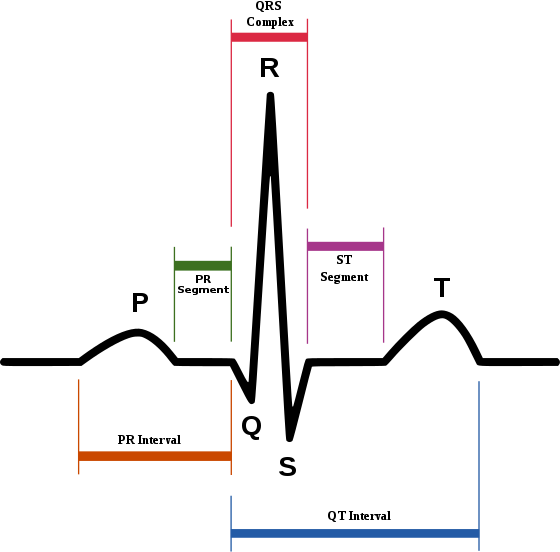

In [5]:
from IPython.display import Image
Image("560px-SinusRhythmLabels.svg.png", width=450)

### Signal plot with the detected QRS peaks <a name="qrs_plot"></a>

In [6]:
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 4), saveto=None):
    """"
    Plots a signal with its detected QRS peaks
    """

    N = sig.shape[0]
    
    with plt.style.context("seaborn"):
        fig, ax_left = plt.subplots(figsize=figsize)
    
    ax_left.plot(sig, color='cornflowerblue', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='red', label='Peak', markersize=12)

    ax_left.set_title(title)

    ax_left.set_xlabel('Digitalized Signals')
    ax_left.set_ylabel('ECG (mV)', color = 'k')

    plt.show()
    return

### Peaks correction example <a name="peaks_correction"></a>
The output of peaks detector xqrs_detect(...) is a list of indices of detected QRS complexes. These indices are not always reliable and we can correct them using correct_peaks(...) function from same library wfdb. <br>
<br>
correct_peaks(...) arguments:
- sig: signal to be processed
- peaks_inds: array of indices of previously detected peaks
- search_radius: radius within which the original peaks may be shifted
- smooth_window_size: window size of the moving average filter applied on the signal. Peak distance is calculated on the difference between the original and smoothed signal

Here we show what the XQRS algorithm does and how we correct the position of the detected QRS complexes

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


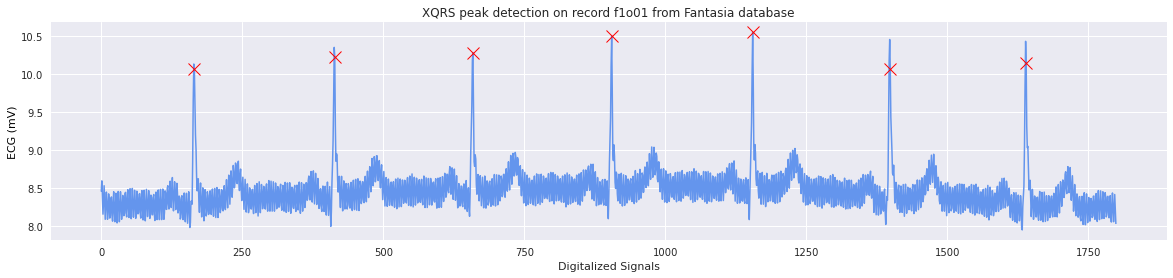

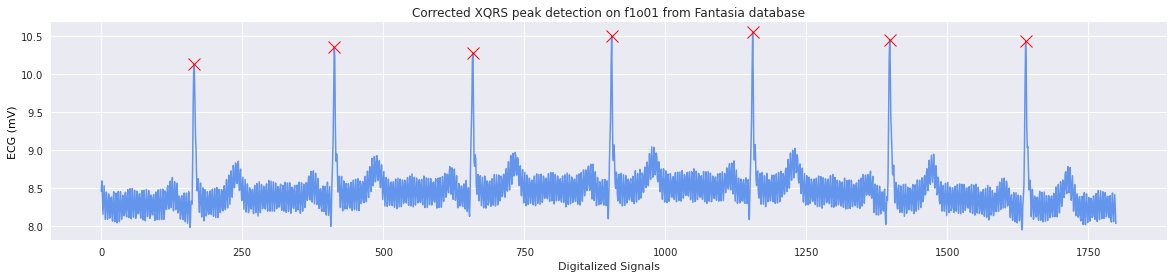

In [7]:
name = "f1o01"  # Choose the subject and create the path
sample = "fantasia-database-1.0.0/" + name 
# Use the right function from the processing subpackage containing signal-processing tools (wfdb) to load its record
record = wfdb.rdrecord(sample, channels = [1], sampfrom = 0, sampto = 1800)  

# Use the XQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.xqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title=f"XQRS peak detection on record {name} from Fantasia database")
    
# Correct the peaks shifting them to local maxima
min_bpm = 30
max_bpm = 200

# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title=f"Corrected XQRS peak detection on {name} from Fantasia database")

# Computation of interbeats $b$ from record <a name="b_computation_rec"></a>

In [8]:
# Load the WFDB record; we only need the ECG data, that are in the second channel (channel number 1 starting from 0) 
# in the fantasia database and in the first channel in the MIT database (channel number 0)
# here we found the code: https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb, but we modified it in order 
# to include the preprocessing function

def qrs_interbeat(record):
    """""
    This function finds the QRS indexes and computes the interbeat values for a record given in input, 
    returning an array that contains them all. It uses predefined functions for signal-processing from WFDB library.
    """

    # Preprocessing
    sig = record.p_signal[:,0]
    sig = preprocess_sig(sig)
    record.p_signal = record.p_signal[:sig.shape[0]]

    # Use the XQRS algorithm to detect QRS locations
    qrs_inds = processing.qrs.xqrs_detect(sig=sig, fs=record.fs)

    # Correct the peaks shifting them to local maxima
    min_bpm = 30
    max_bpm = 200
    # Use the maximum possible bpm as the search radius
    search_radius = int(record.fs * 60 / max_bpm)
    corrected_peak_inds = processing.peaks.correct_peaks(sig, 
                                                         peak_inds=qrs_inds,
                                                         search_radius=search_radius, 
                                                         smooth_window_size=100, peak_dir='up')

    b_i = np.diff(sorted(corrected_peak_inds))
    b_i = b_i/record.fs    #in this way we obtain the timing of the signals
    
    return (b_i)

# Signal detrending and standardization <a name="detr_and_stand"></a>

Detrending is removing a trend from a time series, usually a trend refers to a change in the mean over time. Here we remove a polinomial trend of order 3. We proceed as follow:
1. We integrate the time series $b_i$ obtaining $B(i)=\sum_{j=1}^i b(j)$;
2. We choose a scale s and we divide $B(i)$ into boxes of equal size $2s$, $B_{2s}$ ;
3. For each box we fit a third order polynomial funtion and we subtract it from $B_{2s}$ , the result is divided by the standard deviation to obtain $B^{*}(i)$;
4. Then we evaluate the differences $\Delta_s B(i)= B^*(i+s)-B^*(i)$ by sliding in time over the boxes.

After this process we are ready to study the probability density function of heart-rate increments at different time scales. <br>
In the following image we show an example of how our function for detrending works.

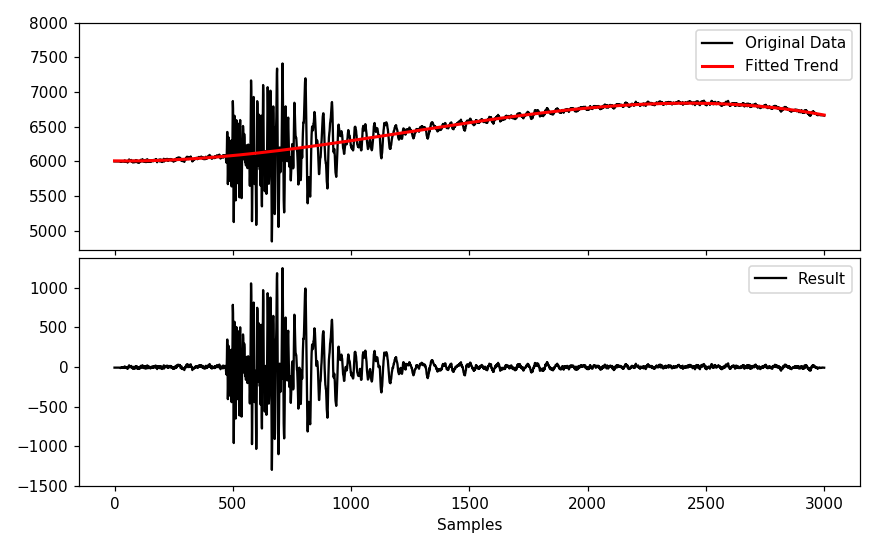

In [9]:
Image("obspy-signal-detrend-polynomial-1.png", width=640)

In [10]:
def detr_and_standardize(b_i, s):
    '''
    b_i: interbeat time series
    s: list of times scale
    
    output : df: dataframe containing in the rows the differences delta_s B(i)
    '''
    # build a cumulative sum over b_i
    B=np.cumsum(b_i) 
    
    # defining the variable we'll need
    Bstar={}
    
    # iterate over the times scale
    for j,k in enumerate(s):   # j goes from 0 to len(s), k follow s 
        c=int(len(B)/(2*k) )   # number of boxes
        
        # defining the variable we'll need
        detrends=[]
        Bstar.setdefault(k, [])

        # removes trends thanks to the function polynomial in the obspy package
        for i in range(c):
            detrend = polynomial(B[i*2*k:(i+1)*2*k], order = 3, plot = False)#z_m
            detrends.append(detrend) 
        vect=np.array(detrends) 
        
        # evaluate B* sliding in time over the boxes
        for i in range(c):    
            for l in range(2*k):
                    Bstar[k].append(detrends[i][l])
    
    DeltaB = {}
    # compute the differences and stores them into a dataframe df
    for l in s:
        std = np.std(Bstar[l])
        DeltaB.setdefault(l, [])
        for g in range( len(Bstar[l])-l):
            diff = (Bstar[l][g+l] - Bstar[l][g])/std
            DeltaB[l].append(diff)
    
    df = pd.DataFrame.from_dict(DeltaB, orient = 'index')
    
    return(df)

# Dataset class <a name="dataset_class"></a>

In [11]:
class Dataset:
    """
    Class for extracting data to analyse from datasets in an easy way
    
    Usage
    -----
    Dataset(dataset) 
    where dataset is a string
    If dataset is "fantasia" or "mit", a default class is created
    Otherwise, a warning is printed to fill essential missing attributes
    
    Functions included
    ------------------
    plot_rec0_info(self)
    
    load_sig_from_name(self, name)
    
    calculate_and_save_b_i(self)
    load_b_i(self)
    b_i_from_name(self, name)
    plot_all_b_i(self)
    
    calculate_and_save_df(self)
    load_df(self)
    """
    def __init__(self, dataset:str):
        self.dataset = dataset
        # Setting basic attributes
        if dataset == "fantasia":
            self.path = './fantasia-database-1.0.0/'
            self.names = [
                'f1o01', 'f1o02', 'f1o03', 'f1o04', 'f1o05', 'f1o06', 'f1o07', 
                'f1o08', 'f1o09', 'f1o10', 'f1y01', 'f1y02', 'f1y03', 'f1y04', 
                'f1y05', 'f1y06', 'f1y07', 'f1y08', 'f1y09', 'f1y10', 'f2o01', 
                'f2o02', 'f2o03', 'f2o04', 'f2o05', 'f2o06', 'f2o07', 'f2o08', 
                'f2o09', 'f2o10', 'f2y01', 'f2y02', 'f2y03', 'f2y04', 'f2y05', 
                'f2y06', 'f2y07', 'f2y08', 'f2y09', 'f2y10'
            ]
            self.bad_names = []
            self.rec0 = wfdb.rdrecord(self.path + self.names[0])
            self.channel = 1
        elif dataset == "mit":
            self.path = './mit-bih-normal-sinus-rhythm-database-1.0.0/'
            self.names = [
                '16265', '16272', '16273', '16420', '16483', '16539', '16773',
                '16786', '16795', '17052', '17453', '18177', '18184', '19088',
                '19090', '19093', '19140', '19830']
            self.bad_names = ['16272']
            self.rec0 = wfdb.rdrecord(self.path + self.names[0])
            self.channel = 0
        else:
            self.path = None
            self.names = None
            self.bad_names = []
            self.rec0 = None
            self.channel = None
            print("WARNING: dataset not found. Please manually define attributes (path, names, rec0, channel)")
        
    def plot_rec0_info(self):
        """
        Plots the record saved in class and print all information included in it
        """
        with plt.style.context("seaborn"):
            wfdb.plot_wfdb(record=self.rec0,
                           title=f"Record {self.rec0.record_name} from {self.dataset} database",
                          figsize=(15,10))
        print(self.rec0.__dict__)
            
    def load_sig_from_name(self, name:str):
        """
        Returns the corresponding signal, in the list included in the class,
        to the name taken as argument.
        If the signal can't be found, raises an Exception
        """
        if not (name in self.names):
            raise Exception(f"Error: signal {name} not found") 
        record = wfdb.rdrecord(self.path + name, sampfrom=0, channels=[self.channel])
        sig = record.p_signal[:,0]
        return sig
        
    def calculate_and_save_b_i(self):
        """
        For every patient name in class' dataset, computes b_i and appends it to a list
        Then saves to external file
        """
        b_i = []
        for name in self.names:
            print(f"Computing b_i from {name}")
            record = wfdb.rdrecord(self.path + name, sampfrom=0, channels=[self.channel])
            b_i.append(qrs_interbeat(record))
        with open(f"b_i_{self.dataset}.pkl", 'wb') as fid:
            pickle.dump(b_i, fid)
    
    def load_b_i(self):
        """
        Returns list of b_i computed previously on patients of class' dataset
        b_i is loaded from an external file. If this file doesn't exist, an exception is raised
        """
        try:
            with open(f"b_i_{self.dataset}.pkl", 'rb') as fid:
                b_i = pickle.load(fid)
                return b_i
        except:
            raise Exception(f"b_i_{self.dataset}.pkl not found. Call calculate_and_save_b_i() function first.")
    
    def b_i_from_name(self, name:str):
        """
        Loads the external file with b_i list and searches inside the b_i corresponding to name taken as argument
        If file doesn't exist, an exception is raised
        """
        if name in self.names:
            index = self.names.index(name)
            return self.load_b_i()[index]
        else:
            raise Exception(f"Name {name} not found.")
    
    def plot_all_b_i(self):
        """
        Plot all b_i in b_i list, before and after cleaning processing
        """
        # Matplotlib gives warning if number of figures in a single output is > 20
        mpl.rc('figure', max_open_warning = 0)

        for i in range(len(self.names)):
            b_test = self.b_i_from_name(self.names[i])
            with plt.style.context("seaborn"):
                fig, ax = plt.subplots(ncols=2, figsize=(20,2))
            ax[0].plot(b_test)
            ax[0].set_title(f"Interbeats intervals $b$, computed from {self.names[i]} patient")
            ax[0].set_xlabel("i-th beat")
            ax[0].set_ylabel("$b(i) [sec]$")

            b_test = clean_b_i(b_test)
            ax[1].plot(b_test)
            ax[1].set_title(f"Cleaned up interbeats intervals $b$, computed from {self.names[i]} patient")
            ax[1].set_xlabel("i-th beat")
            ax[1].set_ylabel("$b(i) [sec]$")

        mpl.rc('figure', max_open_warning = 20)
    
    def calculate_and_save_df(self):
        """
        For every b_i in b_i list, computes standardized $\Delta B(i)$ and appends it to a list
        Then it creates a dataframe from $\Delta B(i)$ list and saves it to external file
        """
        df_list = []
        b_i_list = self.load_b_i()
        for i in range(len(b_i_list)):
            # We skip files too much problematic
            if self.names[i] in self.bad_names:
                continue
            b_i = b_i_list[i]
            b_i = clean_b_i(b_i)
            df = detr_and_standardize(b_i, s_list)
            mask = df.isna()
            df = df[mask == False]
            df_list.append(df)
        df = pd.concat(df_list, axis = 1)
        with open(f"df_{self.dataset}.pkl", "wb") as fid:
            pickle.dump(df, fid)
    
    def load_df(self):
        """
        Returns dataframe of $\Delta B(i)$ computed previously
        Dataframe is loaded from an external file. If this file doesn't exist, an exception is raised
        """
        try:
            with open(f"df_{self.dataset}.pkl", 'rb') as fid:
                df = pickle.load(fid)
                return df
        except:
            raise Exception(f"df_{self.dataset}.pkl not found. Call calculate_and_save_df() function first.")

### Instantiating Dataset classes <a name="class_instantiating"></a>

In [12]:
fantasia_ds = Dataset("fantasia")
mit_ds = Dataset("mit")

### Computing and saving interbeat intervals $b$ and $\Delta_s B$ <a name="b_computing"></a>

In [13]:
#----------------------------------------------------------------
# Run only once. After that, we can just load corresponding files
#----------------------------------------------------------------

# fantasia_ds.calculate_and_save_b_i()
# mit_ds.calculate_and_save_b_i()
# fantasia_ds.calculate_and_save_df()
# mit_ds.calculate_and_save_df()

### Loading interbeat intervals $b$ and standardized $\Delta_s B$ <a name="b_loading"></a>

In [14]:
b_i_fantasia = fantasia_ds.load_b_i()
b_i_mit = mit_ds.load_b_i()

df_fantasia = fantasia_ds.load_df()
df_mit = mit_ds.load_df()

# The peaks distance problem <a name="peaks_distance_problem"></a>
Data had a far from perfect sampling. We already coded a preprocessing function, that acts directly on signal data. We observed that, even using the processed signal, some artifacts in interbeats are generated from peaks detector. As we can see in next graph, there could be some high peaks in interbeat intervals $b$: that is because there are ranges in original signal where peaks detector couldn't find signal peaks. This causes large interbeats values that could be avoided. We therefore decided to clean interbeat intervals $b$ with an suitably defined function.

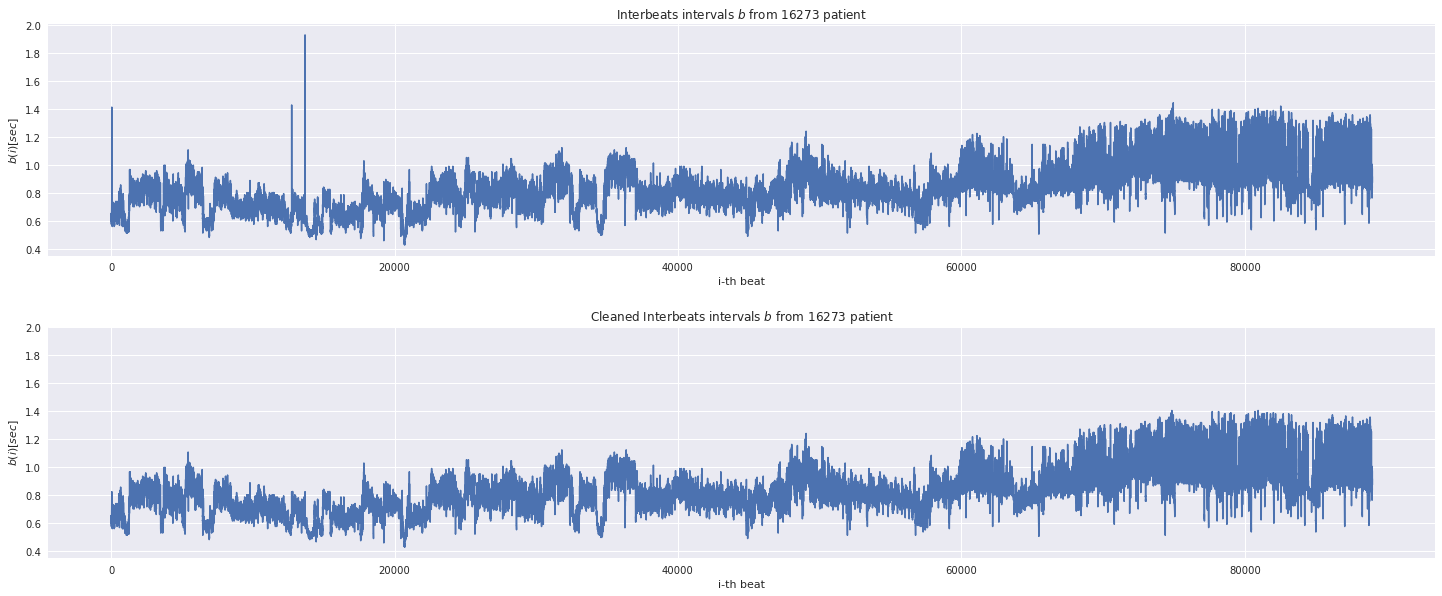

In [15]:
b_test = mit_ds.b_i_from_name(mit_ds.names[2])
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(nrows=2, figsize=(20,8))
fig.tight_layout(h_pad=5)

ax[0].set_title(f"Interbeats intervals $b$ from {mit_ds.names[2]} patient")
ax[0].set_xlabel("i-th beat")
ax[0].set_ylabel("$b(i) [sec]$")
ax[0].plot(b_test)

b_test = clean_b_i(b_test)
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title(f"Cleaned Interbeats intervals $b$ from {mit_ds.names[2]} patient")
ax[1].set_xlabel("i-th beat")
ax[1].set_ylabel("$b(i) [sec]$")
_ = ax[1].plot(b_test)

### Plotting interbeat intervals $b$ before and after cleaning up <a name="plotting_b_before_after_cleaning"></a>
Cleaning function seems to work well for both datasets. We can observe that, even after cleaning, patient 16272 from MIT dataset isn't cleaned correctly. This is because original file is very corrupted, we could preprocess just this signal in a more suitable way, but this would cause to discard most part of signal. We therefore decided to delete this signal from further analysis.

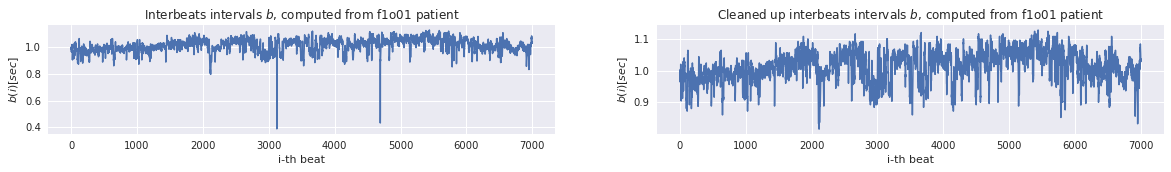

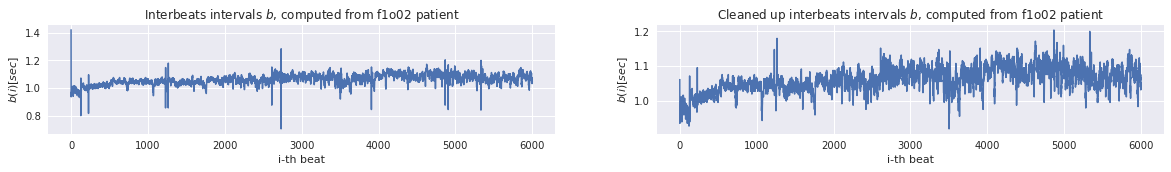

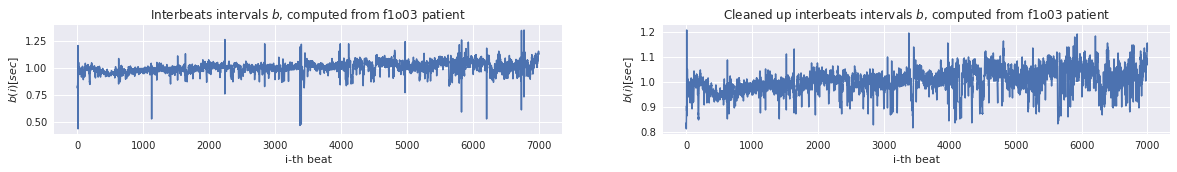

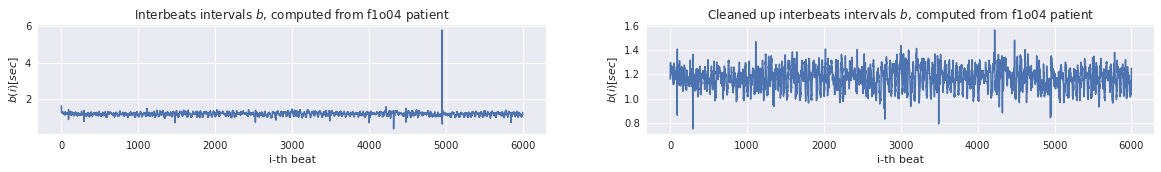

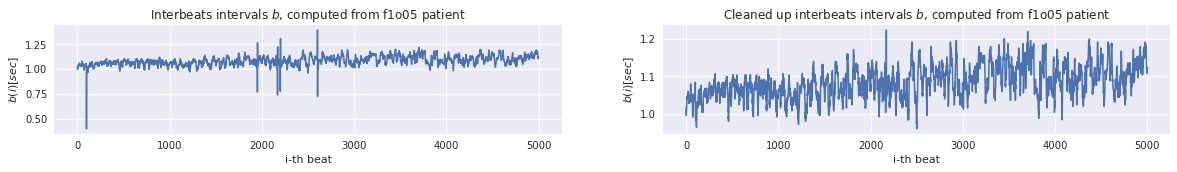

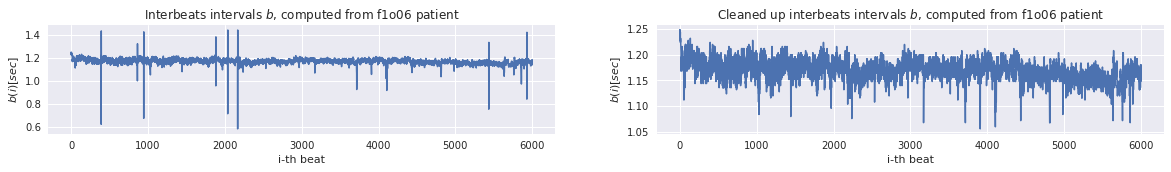

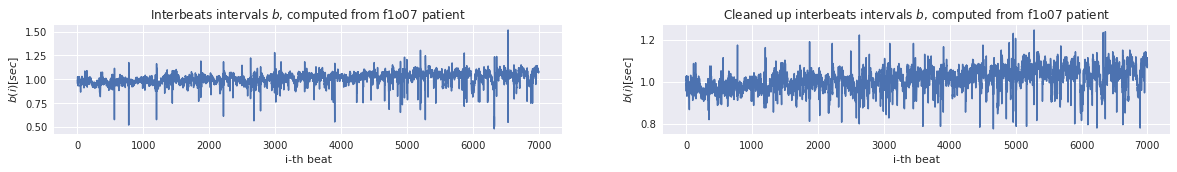

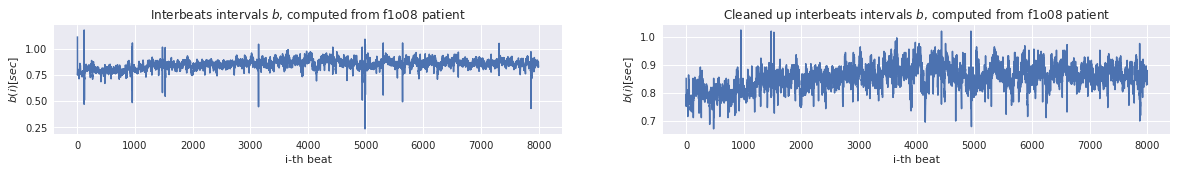

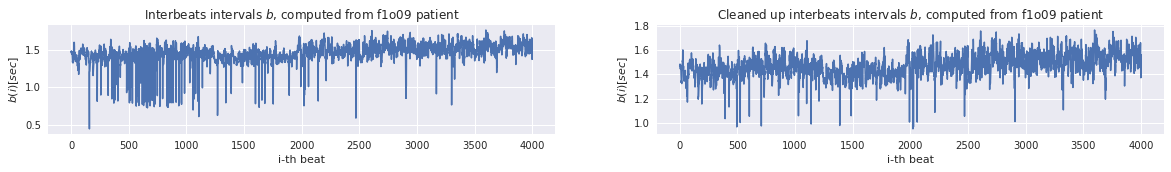

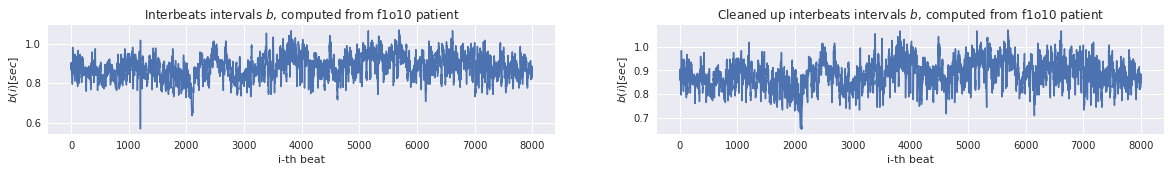

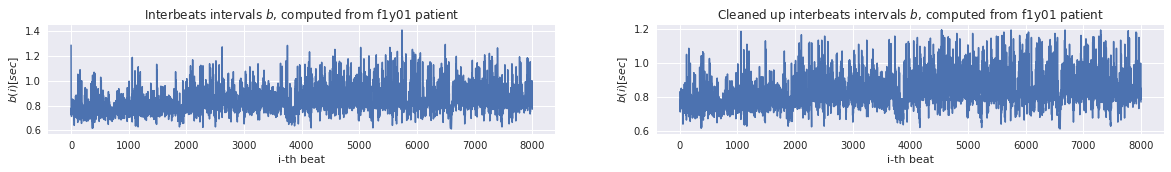

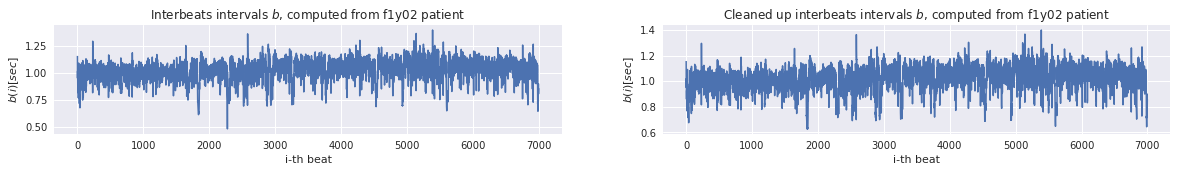

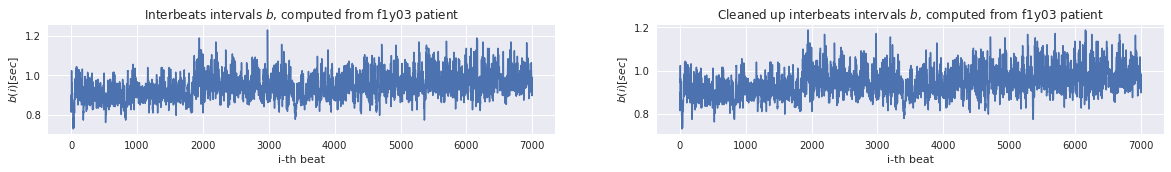

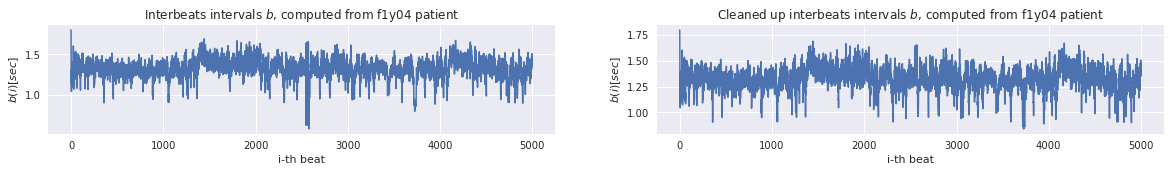

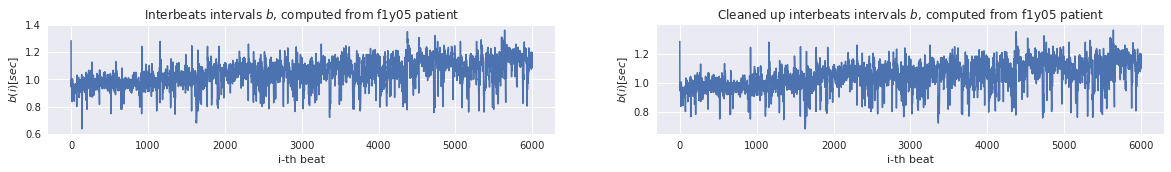

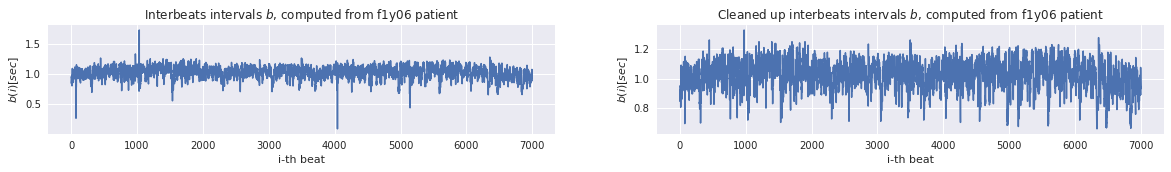

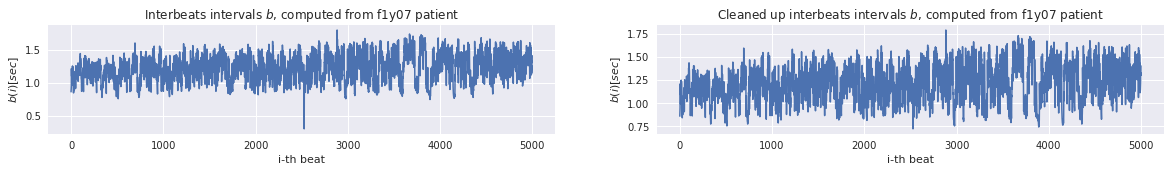

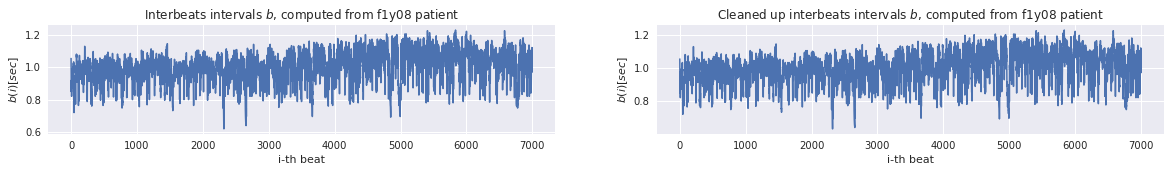

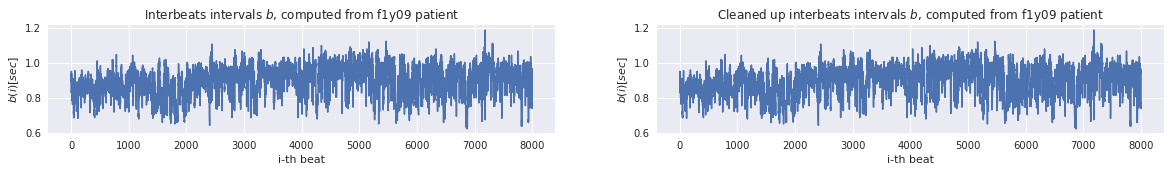

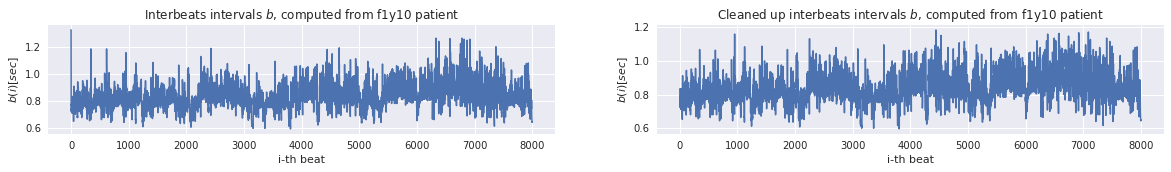

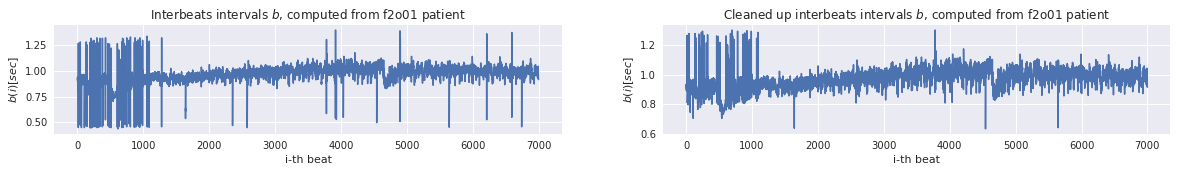

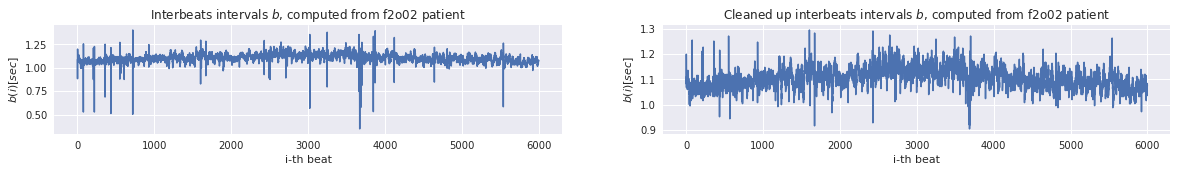

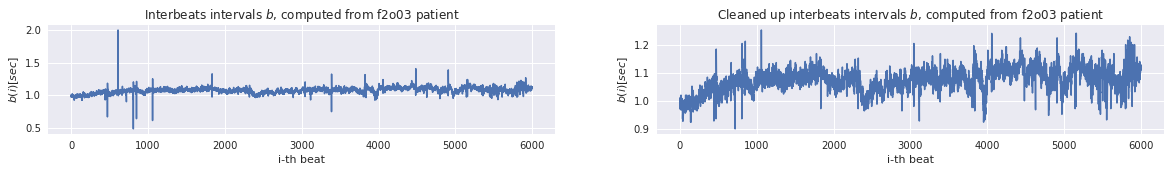

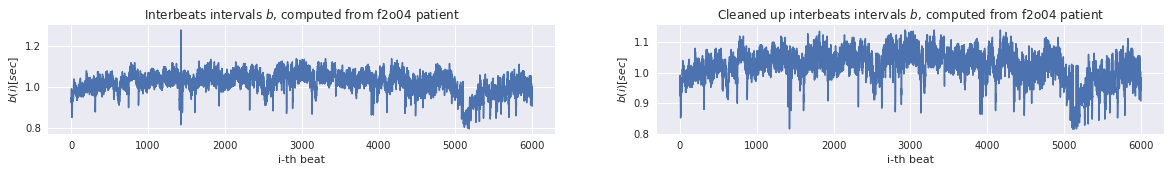

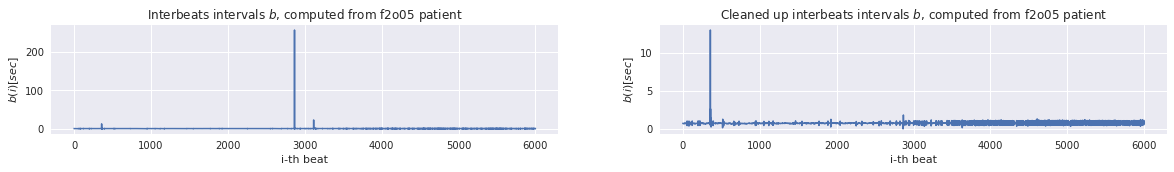

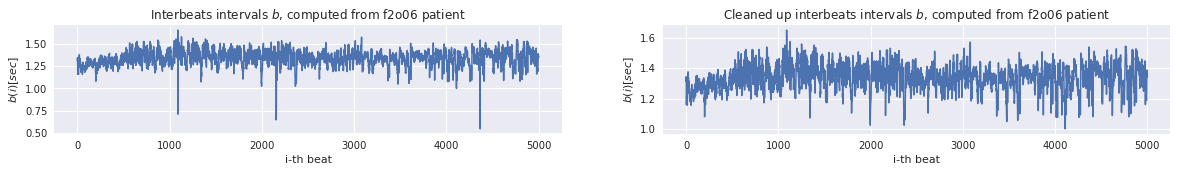

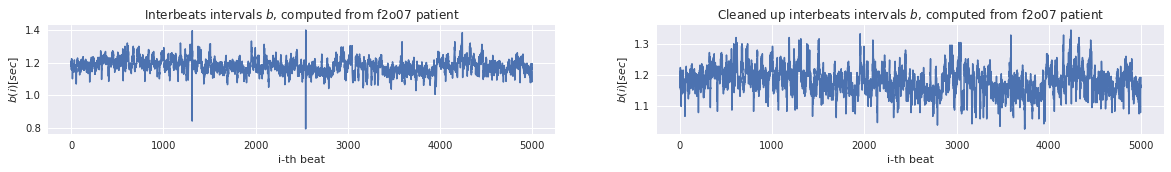

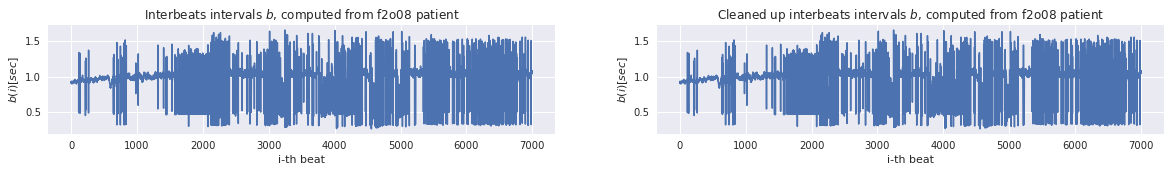

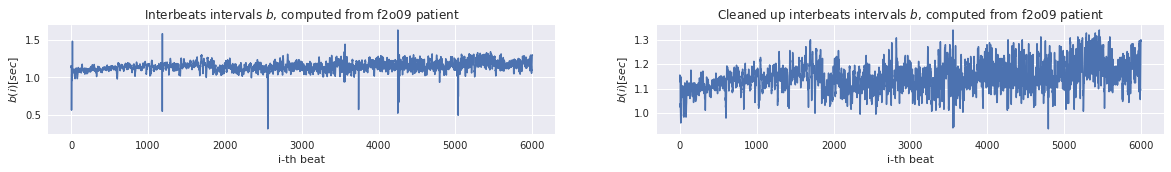

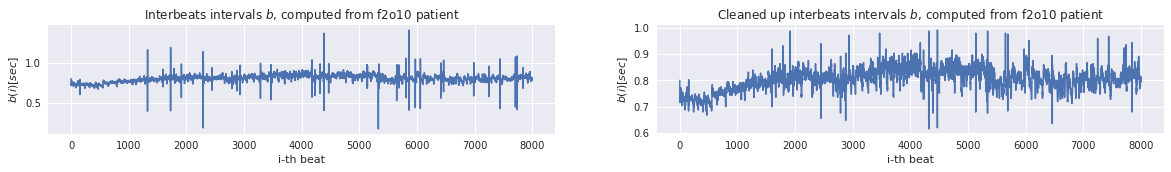

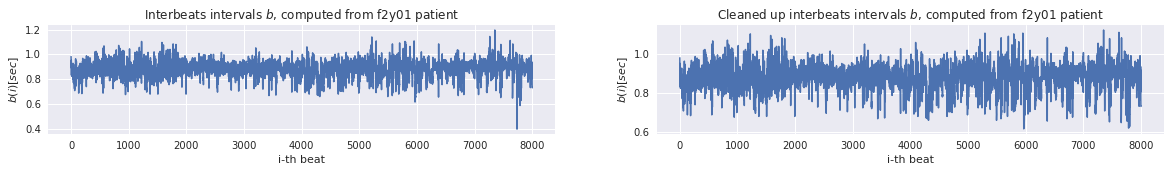

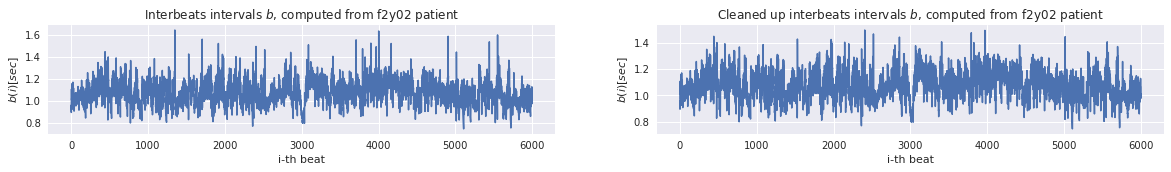

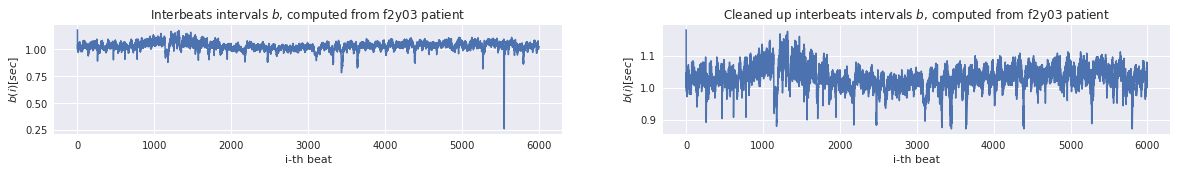

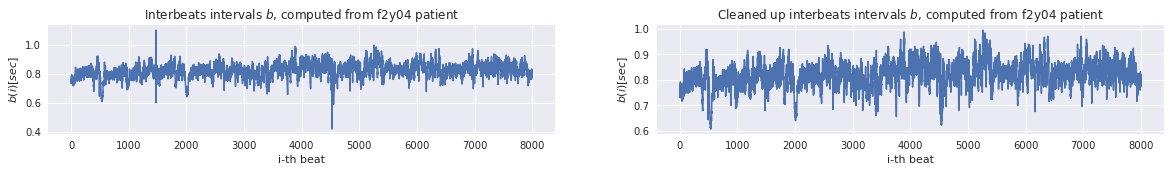

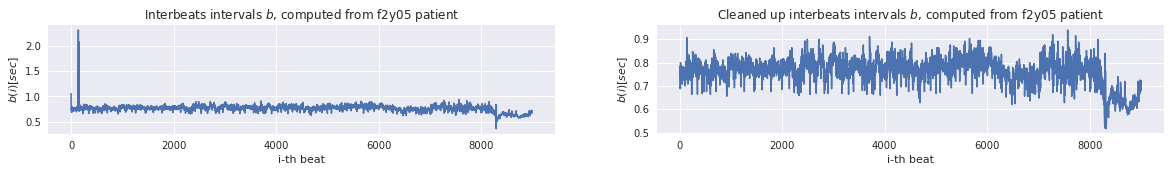

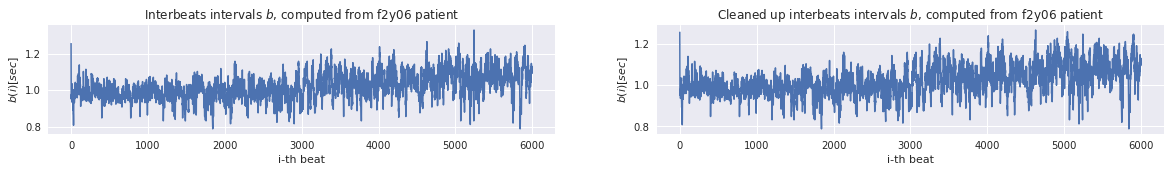

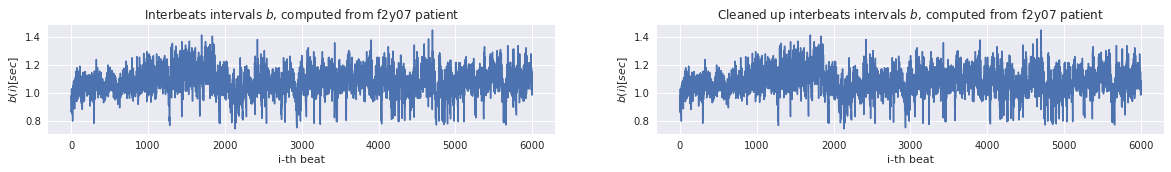

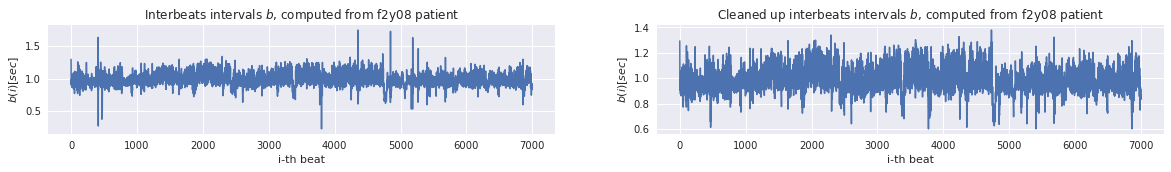

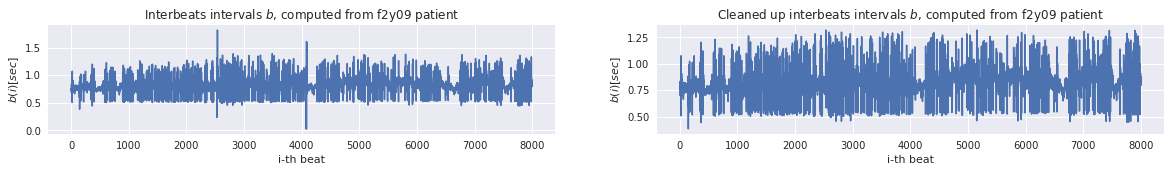

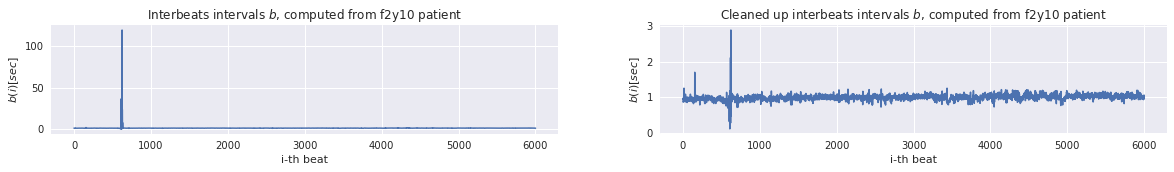

In [16]:
fantasia_ds.plot_all_b_i()

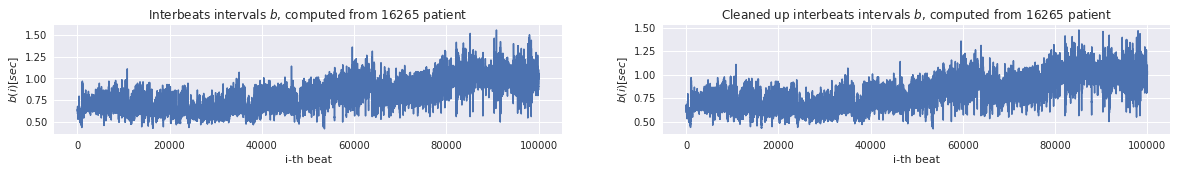

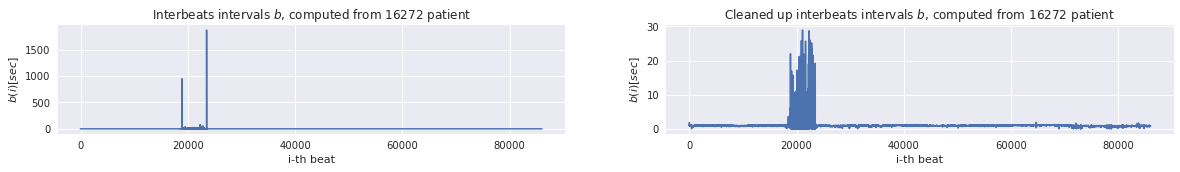

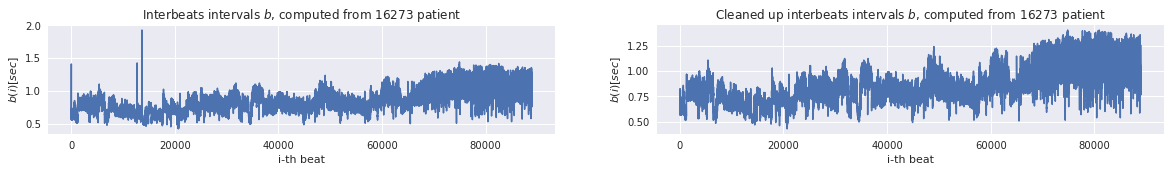

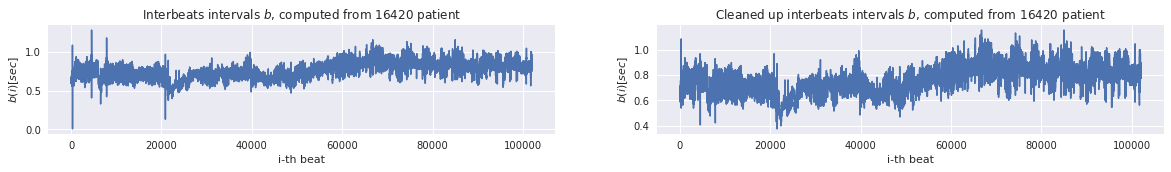

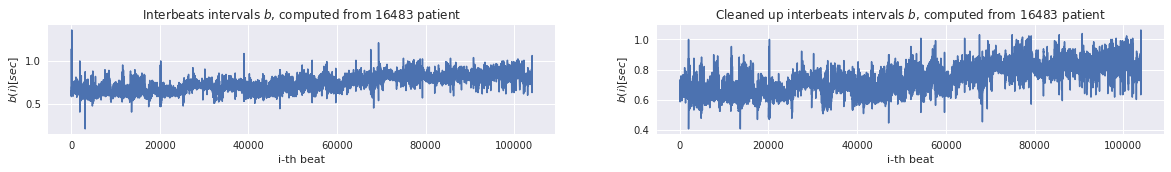

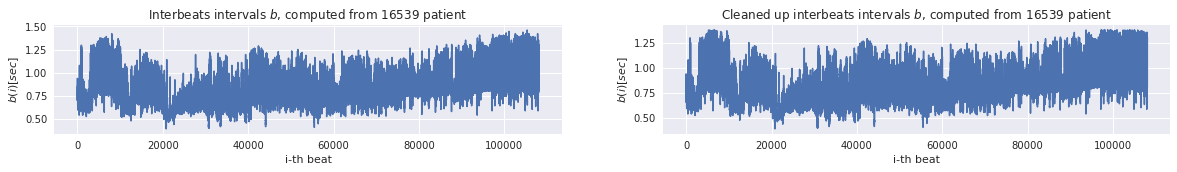

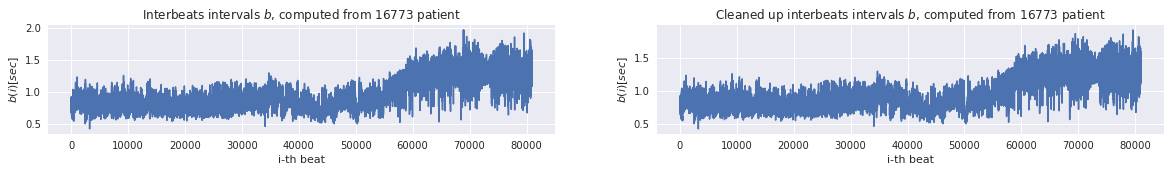

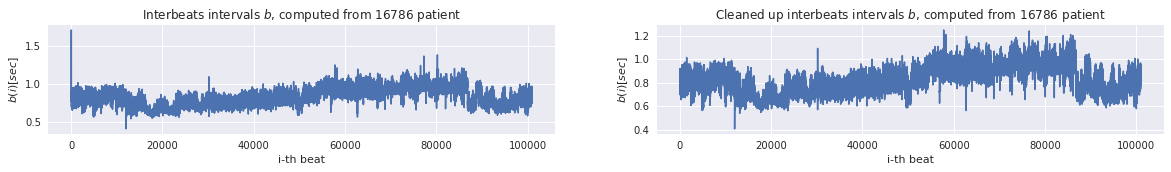

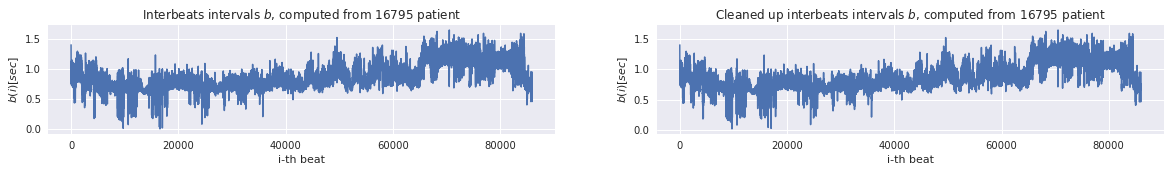

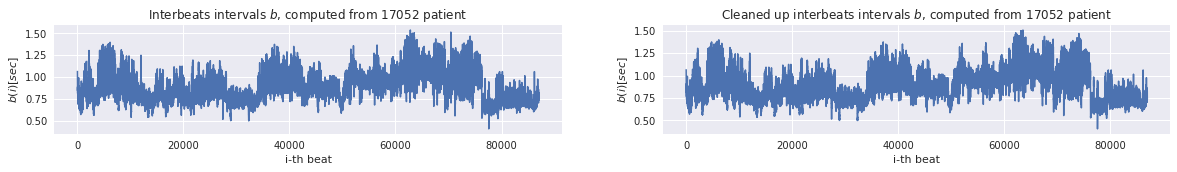

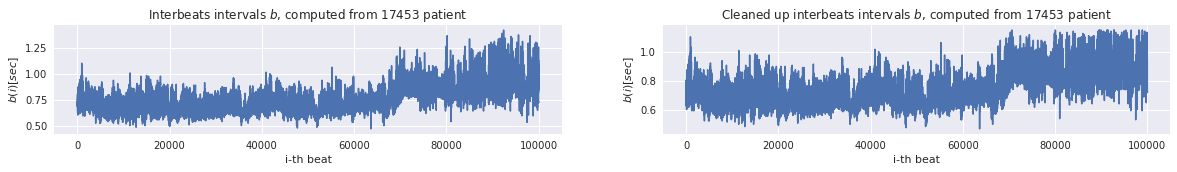

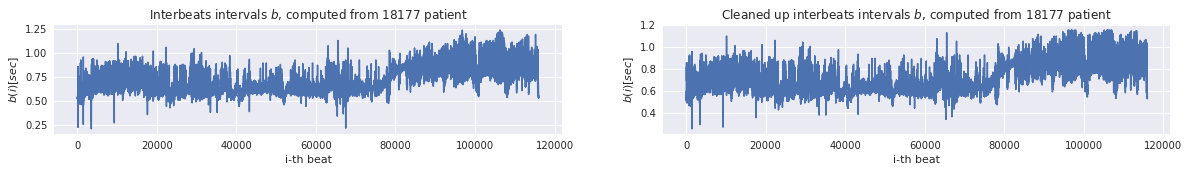

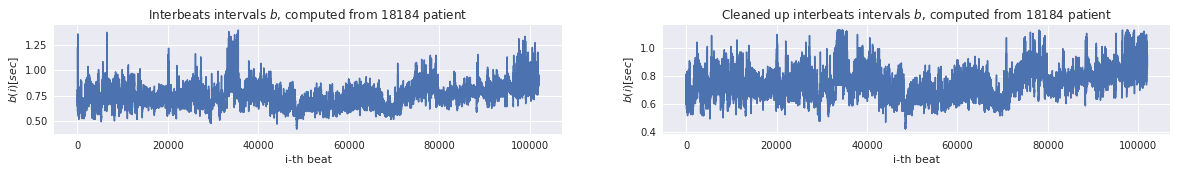

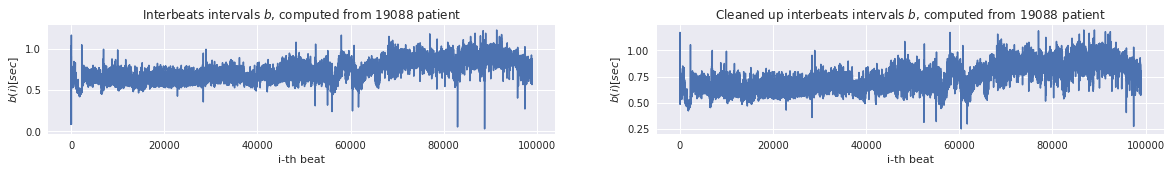

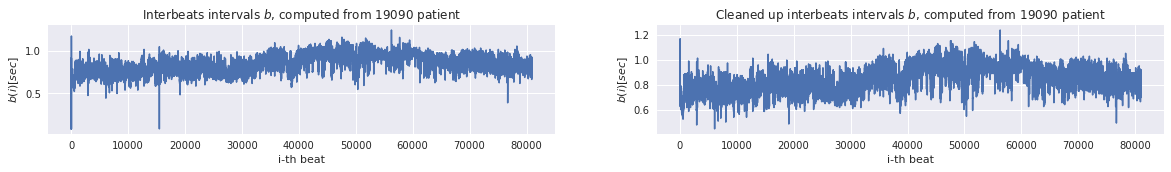

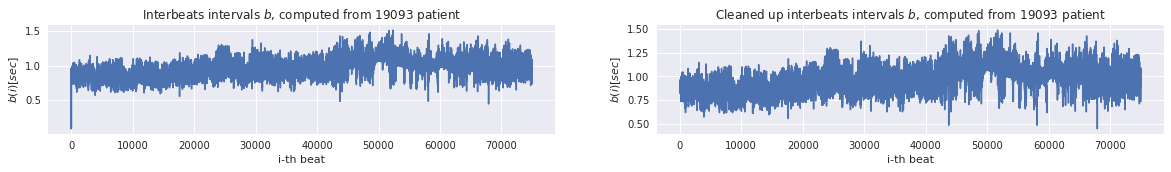

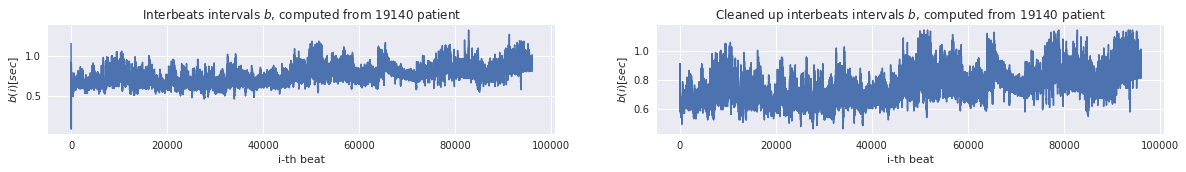

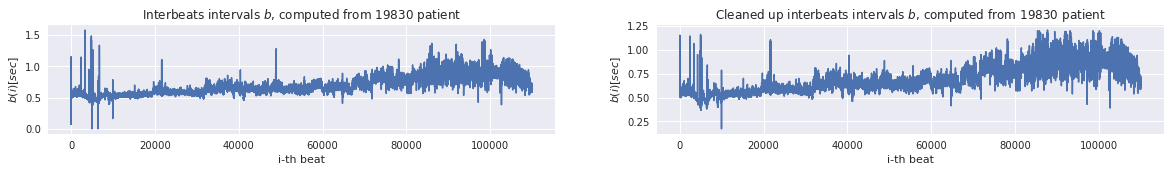

In [17]:
mit_ds.plot_all_b_i()

### Plotting signal from patient 16272 <a name="patient_16272"></a>

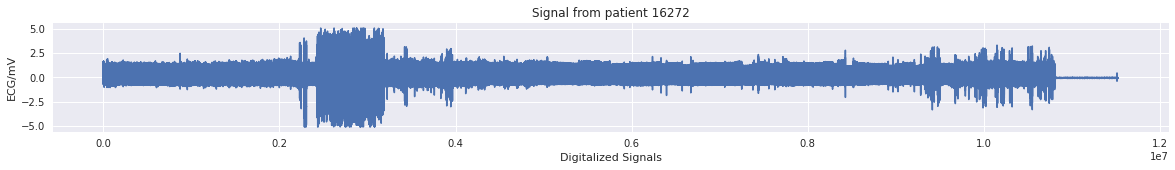

In [18]:
sig = mit_ds.load_sig_from_name("16272")
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize=(20,2))
ax.set_title("Signal from patient 16272")
ax.set_ylabel("ECG/mV")
ax.set_xlabel("Digitalized Signals")
_ = ax.plot(sig)

# Fit and data analysis <a name="fit_and_data_analysis"></a>

In [19]:
# Calculate R2 score (Coefficient of determination) and RMSE (Root-mean-square error)
# but we use log10(data)
def R2_score(y_true, y_fit):
    y_true10, y_fit10 = np.log10(y_true), np.log10(y_fit)
    y_mean10 = y_true10.mean()
    SS_tot = np.sum((y_true10-y_mean10)**2)
    SS_res = np.sum((y_true10-y_fit10)**2)
    return 1 - SS_res/SS_tot

# Root-mean-square deviation and normalized RMSE
# We use log10(data) instead of data, and |<log10(y_true)>| for normalization
def RMSE_NRMSE(y_true, y_fit):
    y_true10, y_fit10 = np.log10(y_true), np.log10(y_fit)
    s = np.sum((y_true10-y_fit10) ** 2)
    n = y_true.shape[0]
    RMSE = np.sqrt(s / n)
    NRMSE = RMSE / np.abs(y_true10.mean())
    return RMSE, NRMSE

## Gaussian fit <a name="gauss"></a>

### Gaussian fit for Fantasia dataset  <a name="gauss_fantasia"></a>

100%|██████████| 10/10 [00:00<00:00, 25.72it/s]


R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.
RMSE and NRMSE values are in agreement with R2 values


$R^2$      RMSE     NRMSE
s                                 
10   -5.131204  3.449715  0.790043
25   -2.738162  2.557086  0.550362
50   -2.201261  2.415195  0.487674
125  -1.941613  2.280201  0.430773
250  -2.094470  2.339528  0.416094
500  -2.409146  2.448349  0.413654
625  -1.510125  2.100413  0.351903
1000 -2.142492  2.370216  0.380797
1250 -1.850989  2.220353  0.354234
1500 -2.211313  2.340763  0.367987

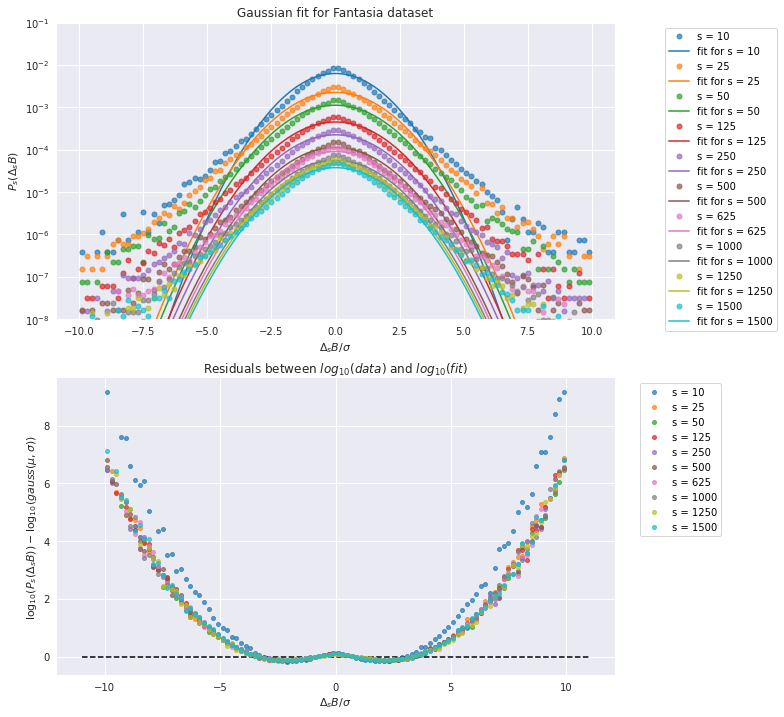

In [20]:
# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Gaussian fit for Fantasia dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(gauss" + "(\mu, \sigma))$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].hlines(0, -11, 11, linestyles="dashed", colors="k")

# Output table
table = {"s":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_fantasia.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y=y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=100, range=(-10, 10))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete empty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    mu, sigma = norm.fit(y)

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=5, alpha=0.7, label=f"s = {s}")
    # Plot fit
    y_fit = norm.pdf(bins_c_fit, mu, sigma)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=4, alpha=0.7, label=f"s = {s}")
    
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

### Gaussian fit for MIT dataset <a name="gauss_mit"></a>

100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.
RMSE and NRMSE values are in agreement with R2 values


$R^2$      RMSE     NRMSE
s                                  
10   -10.020328  4.038930  0.952666
25    -4.945720  2.840395  0.630130
50    -4.646361  2.776014  0.577348
125   -4.619911  2.770994  0.532158
250   -4.486621  2.757182  0.500000
500   -4.481245  2.767984  0.475917
625   -4.413862  2.751411  0.464985
1000  -4.609535  2.780468  0.454693
1250  -4.348186  2.753816  0.442181
1500  -4.471235  2.766994  0.439240

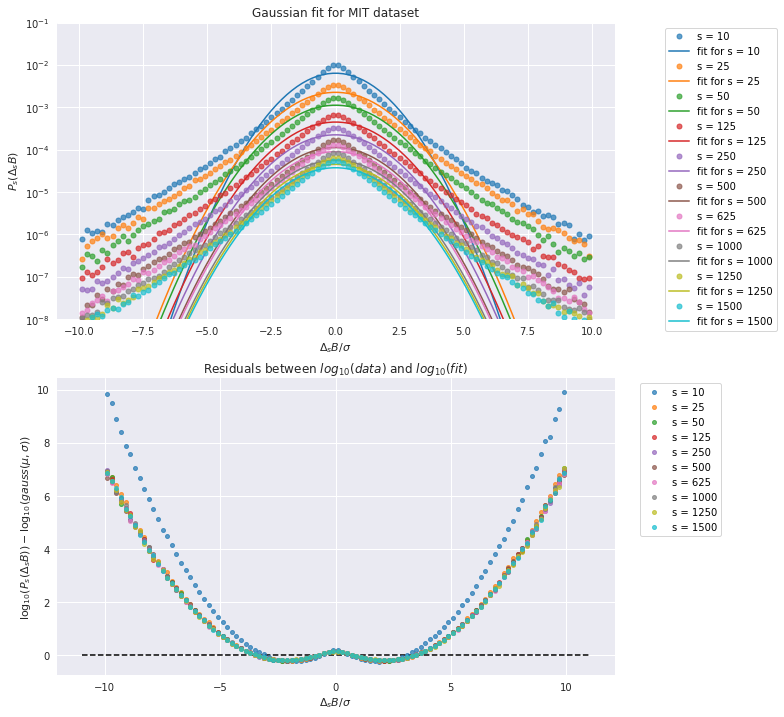

In [21]:
# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Gaussian fit for MIT dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(gauss" + "(\mu, \sigma))$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].hlines(0, -11, 11, linestyles="dashed", colors="k")

# Output table
table = {"s":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_mit.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y=y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=100, range=(-10, 10))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete emty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    mu, sigma = norm.fit(y)

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=5, alpha=0.7, label=f"s = {s}")
    # Plot Fit
    y_fit = norm.pdf(bins_c_fit, mu, sigma)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot Residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=4, alpha=0.7, label=f"s = {s}")
    
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

## Castaing fit <a name="castaing"></a>
We fit the data to the following equation, based on the Castaing's function:

 $$\Pi (x) = \int_{0}^{+\infty} {\frac{1}{\sigma \sqrt{2\pi}}} exp(-\frac{x^2}{2\sigma^2}){\frac{1}{\lambda \sqrt{2\pi}} exp(- \frac{ln^2 (\sigma)}{2\lambda^2}) \frac{d\sigma}{\sigma}}$$
 
More details in the theoretical PDF.

In [22]:
def Castaing_integral(x, lambd):
    result = scipy.integrate.quad(
        lambda sigma: 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma)**2/lambd**2) / 2),
    0, np.inf)
    return result[0]
# scipy_integrate accepts only scalar functions, we can vectorize it this way
Castaing_integral = np.vectorize(Castaing_integral)

### Castaing fit for Fantasia dataset <a name="castaing_fantasia"></a>

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

We consider R2 scores good enough for Castaing fit.
RMSE and NRMSE values are in agreement with R2 values


$\lambda$  $\sigma_{\lambda}$     $R^2$      RMSE     NRMSE
s                                                                
10     0.473368            0.005640  0.957413  0.279611  0.061276
25     0.491463            0.004442  0.974332  0.213097  0.043352
50     0.491736            0.004835  0.969566  0.235344  0.044989
125    0.485478            0.004449  0.976288  0.204286  0.036832
250    0.493216            0.005205  0.965041  0.252035  0.042511
500    0.488500            0.004677  0.970484  0.233375  0.037326
625    0.482005            0.004672  0.973404  0.216460  0.034599
1000   0.492174            0.005349  0.967076  0.236604  0.036811
1250   0.497426            0.005560  0.963430  0.252589  0.038425
1500   0.487518            0.005279  0.968173  0.230540  0.034993

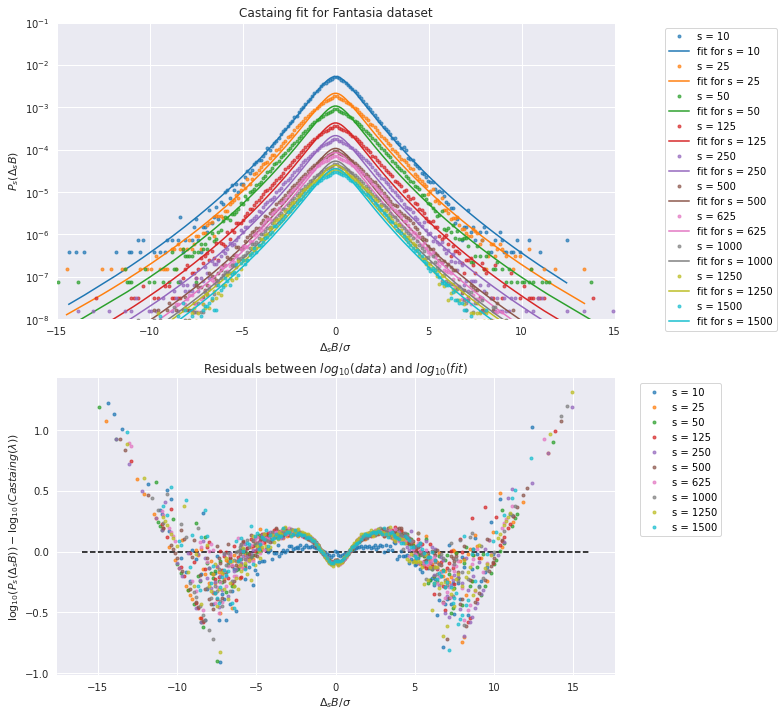

In [23]:
# Histograms' parameters
n_bins = 250
hist_range = 15
marker_size = 3

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Castaing fit for Fantasia dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)
ax[0].set_xlim(-hist_range, hist_range)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(Castaing" + "(\lambda))$")
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Saving lambdas' values and errors for later
lambdas_fantasia = np.zeros(s_list.shape)
lambdas_err_fantasia = np.zeros(s_list.shape)

# Output table
table = {"s":[], "$\lambda$":[], "$\sigma_{\lambda}$":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_fantasia.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete emty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    def C_log10(x, lambd):
        c = Castaing_integral(x, lambd)
        return np.log10(c / np.sum(c))
    
    histo_log = np.log10(histo_fit / np.sum(histo_fit))
    pars, pcov = curve_fit(f=C_log10, xdata=bins_c_fit, ydata=histo_log, p0=0.4, bounds=[0.1,1])
    std = np.sqrt(pcov[0,0])
    # Save lambda and lambda_err
    lambdas_fantasia[j] = pars[0]
    lambdas_err_fantasia[j] = std

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
    # Plot Fit
    y_fit = Castaing_integral(bins_c_fit, *pars)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot Residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
        
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    table["$\lambda$"].append(pars[0])
    table["$\sigma_{\lambda}$"].append(std)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("We consider R2 scores good enough for Castaing fit.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

### Castaing fit for MIT dataset <a name="castaing_mit"></a>

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

We consider R2 scores good enough for Castaing fit.
RMSE and NRMSE values are in agreement with R2 values


$\lambda$  $\sigma_{\lambda}$     $R^2$      RMSE     NRMSE
s                                                                
10     0.500855            0.002757  0.983327  0.200958  0.039062
25     0.526528            0.002662  0.984443  0.197086  0.035344
50     0.523739            0.002814  0.984290  0.197111  0.034074
125    0.520819            0.002564  0.987091  0.177068  0.028759
250    0.514904            0.003032  0.982591  0.207467  0.032259
500    0.507624            0.003042  0.983090  0.203101  0.030405
625    0.508626            0.003077  0.982087  0.210987  0.030944
1000   0.517139            0.002872  0.985702  0.184026  0.026496
1250   0.511083            0.003183  0.982208  0.206701  0.029311
1500   0.517306            0.002848  0.983260  0.205453  0.028162

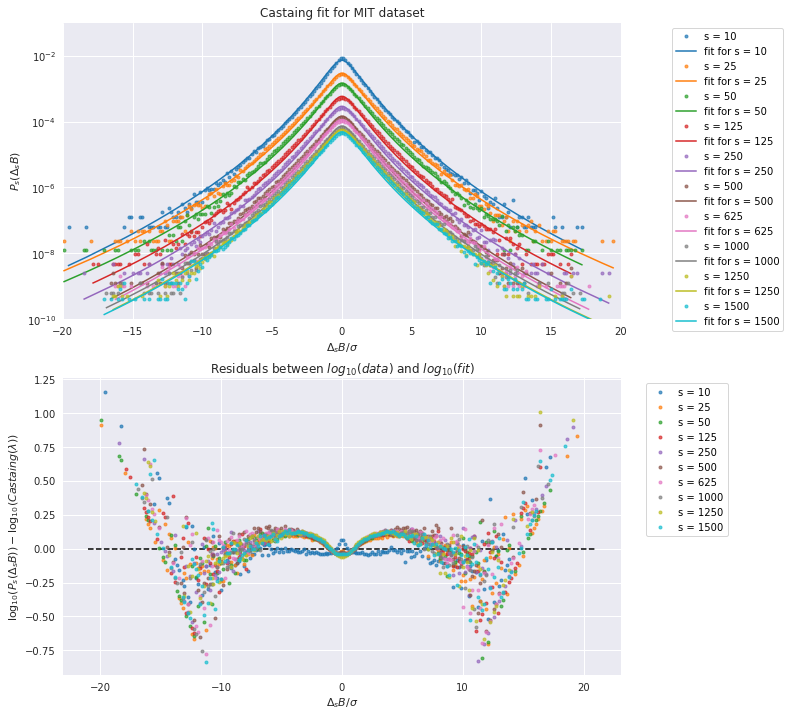

In [24]:
# Histograms' parameters
n_bins = 250
hist_range = 20
marker_size = 3

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Castaing fit for MIT dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-10, 0.1)
ax[0].set_xlim(-hist_range, hist_range)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(Castaing" + "(\lambda))$")
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Saving lambdas' values and errors for later
lambdas_mit = np.zeros(s_list.shape)
lambdas_err_mit = np.zeros(s_list.shape)

# Output table
table = {"s":[], "$\lambda$":[], "$\sigma_{\lambda}$":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_mit.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete emty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    def C_log10(x, lambd):
        c = Castaing_integral(x, lambd)
        return np.log10(c / np.sum(c))
    
    histo_log = np.log10(histo_fit / np.sum(histo_fit))
    pars, pcov = curve_fit(f=C_log10, xdata=bins_c_fit, ydata=histo_log, p0=0.4, bounds=[0.1,1])
    std = np.sqrt(pcov[0,0])
    # Save lambda and lambda_err
    lambdas_mit[j] = pars[0]
    lambdas_err_mit[j] = std

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
    # Plot Fit
    y_fit = Castaing_integral(bins_c_fit, *pars)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot Residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
        
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    table["$\lambda$"].append(pars[0])
    table["$\sigma_{\lambda}$"].append(std)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("We consider R2 scores good enough for Castaing fit.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

### Dependence of fitting parameter $\lambda^2$ on the scale $s$ for Fantasia dataset and MIT dataset <a name="lambda_dependence"></a>

In [25]:
def plot_lambda2(lambdas_fantasia, lambdas_err_fantasia, lambdas_mit, lambdas_err_mit):
    """
    Plots the various values of lambda^2 parameter of Castaing function, obtained from previous fits,
    for Fantasia and MIT Dataset
    """
    with plt.style.context("seaborn"):
        fig, ax = plt.subplots(figsize=(9,8))
    ax.set_ylim([0.2, 0.3])
        
    # Fantasia dataset
    lambdas_sqr_fantasia = lambdas_fantasia**2
    # err(lambda^2) = |d/dx(lambda^2)|*err(lambda)
    lambdas_err_sqr_fantasia = 2 * lambdas_fantasia * lambdas_err_fantasia

    ax.set_title("Dependence of fitting parameter $\lambda^2$ on the scale $s$")
    ax.set_xlabel("$s$")
    ax.set_ylabel("$\lambda^2$")
    ax.set_xscale("log")
    ax.set_yscale("linear")
    ax.plot(s_list, lambdas_sqr_fantasia, 'o', color='deepskyblue')
    ax.fill_between(s_list,
                    lambdas_sqr_fantasia-2*lambdas_err_sqr_fantasia,
                    lambdas_sqr_fantasia+2*lambdas_err_sqr_fantasia,
                    alpha=0.2, color='turquoise', label="$2\sigma$ confidence Fantasia")
    ax.errorbar(x = s_list, y = lambdas_sqr_fantasia, yerr = lambdas_err_sqr_fantasia, capsize=5)
    ax.hlines(lambdas_sqr_fantasia.mean(), 8, 2000, colors="k", linestyles="--")
    ax.text(6.4, lambdas_sqr_fantasia.mean()-0.005, '$\lambda^2_{Fantasia} = %.3f \,$' %lambdas_sqr_fantasia.mean(), size = 11)
    
    # MIT dataset
    lambdas_sqr_mit = lambdas_mit**2
    # err(l^2) = |d/dx(l^2)|*err(l)
    lambdas_err_sqr_mit = 2 * lambdas_mit * lambdas_err_mit
    
    ax.plot(s_list, lambdas_sqr_mit, 'o', color='green')
    ax.fill_between(s_list,
                    lambdas_sqr_mit-2*lambdas_err_sqr_mit,
                    lambdas_sqr_mit+2*lambdas_err_sqr_mit,
                    alpha=0.2, color='green', label="$2\sigma$ confidence MIT")
    ax.errorbar(x = s_list, y = lambdas_sqr_mit, yerr = lambdas_err_sqr_mit, capsize=5)
    ax.hlines(lambdas_sqr_mit.mean(), 8, 2000, colors="k", linestyles="--", label="Average")
    ax.text(6.4, lambdas_sqr_mit.mean()+0.005, '$\lambda^2_{MIT} = %.3f \,$' %lambdas_sqr_mit.mean(), size = 11)
    
    ax.legend()

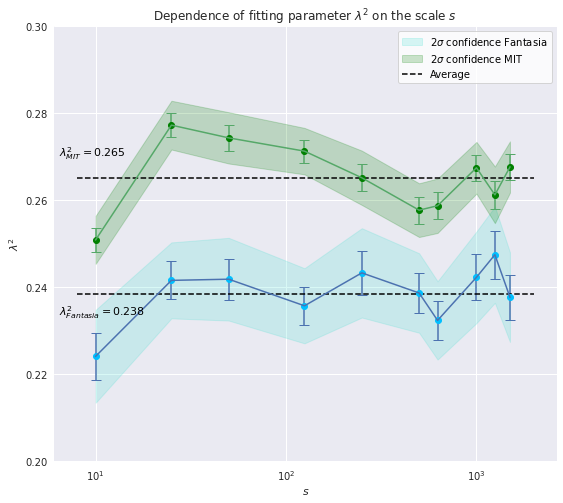

In [26]:
plot_lambda2(lambdas_fantasia, lambdas_err_fantasia, lambdas_mit, lambdas_err_mit)

## Collapse plot <a name="collapse"></a>
In order to qualitatively test the scale invariance of the increments PDFs we can use the collapse plot.

### Collapse Plot for Fantasia dataset <a name="collapse_fantasia"></a>

Best pars: [ 0.46503266], Covariance matrix: [[  5.50237313e-06]]
lambda's value from averaging previous list: 0.4883±0.0016
lambda's value from fit: 0.4650±0.0023
Standard variable: 130.34
Level of confidence: 0.05
We try a two-tailed test
Confidence interval: [-1.96, 1.96]
We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors


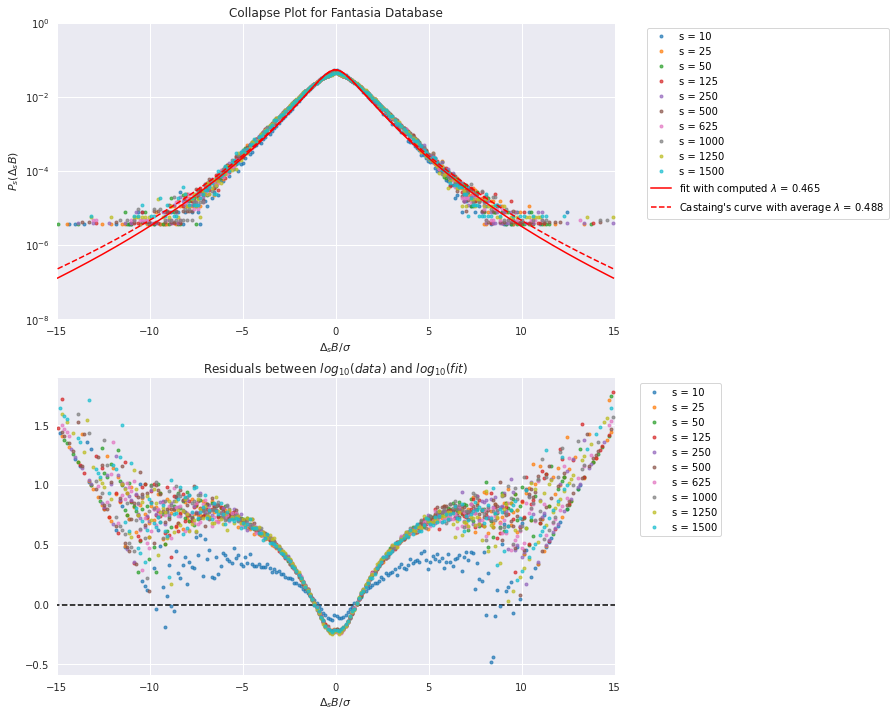

In [27]:
# Histograms' parameters
n_bins = 250
hist_range = 15
marker_size = 3
# All values of histograms.
histo_tot = np.zeros(n_bins)

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Collapse Plot for Fantasia Database")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1)
ax[0].set_xlim([-hist_range,hist_range])

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_xlim([-hist_range,hist_range])
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Generate histogram data and plot data points
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_fantasia.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2

    histo_tot += histo
    
    histo_fit_norm = histo/(np.sum(histo))
 
    # Plot data
    ax[0].plot(bins_centers, histo_fit_norm, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Fit
def C_log(x, lambd):
    c = Castaing_integral(x, lambd)
    return np.log10(c / (np.sum(c)))
histo_tot_norm = histo_tot / np.sum(histo_tot)
indices = histo_tot_norm != 0
histo_log = np.log10(histo_tot_norm[indices])

pars, pcov = curve_fit(f=C_log, 
                       xdata=bins_centers[indices], 
                       ydata=histo_log, 
                       p0=0.4, bounds=[0.1,1])
print(f"Best pars: {pars}, Covariance matrix: {pcov}")
std = np.sqrt(pcov[0,0])
# Plot Fit
y_fit = Castaing_integral(bins_centers, *pars) 
y_fit = y_fit / (np.sum(y_fit))
ax[0].plot(bins_centers, y_fit, color=color_fit, label=f"fit with computed $\lambda$ = {pars[0]:.3f}")
# Plot Castaing's curve with lambda = average
lambda_mean_fantasia = lambdas_fantasia.mean()
y_fit_mean = Castaing_integral(bins_centers, lambda_mean_fantasia)
y_fit_mean = y_fit_mean / np.sum(y_fit_mean)
ax[0].plot(bins_centers, y_fit_mean, "--", color=color_fit, 
           label=f"Castaing's curve with average $\lambda$ = {lambda_mean_fantasia:.3f}")

# Generate histogram data and plot residuals
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_fantasia.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    y = y*y.std()
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    histo_fit_norm = histo/(np.sum(histo))
    
    # Plot data
    y_fit_res = Castaing_integral(bins_centers, *pars) 
    y_fit_res = y_fit_res / (np.sum(y_fit_res))
    i_hist, i_fit = histo_fit_norm != 0, y_fit_res != 0
    indices = i_hist & i_fit
    residuals_log10 = np.log10(histo_fit_norm[indices])-np.log10(y_fit_res[indices])
    ax[1].plot(bins_centers[indices], residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Plot legends
ax[0].legend(bbox_to_anchor=legend_bbox_fit)
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

# Comparing the two lambdas
lambda_mean_err_fantasia = 1/np.sqrt(np.sum(1/lambdas_err_fantasia**2))
print(f"lambda's value from averaging previous list: {lambda_mean_fantasia:.4f}±{lambda_mean_err_fantasia:.4f}")
print(f"lambda's value from fit: {pars[0]:.4f}±{std:.4f}")

# Compatibility of lambda_fit and lambda_mean
m = lambda_mean_fantasia - pars[0]
# Var[m] = 1/N * (Var[l_fantasia] + Var[l_fit])
m_var = (lambda_mean_err_fantasia**2 + std**2) / bins_centers.shape[0]
m_err = np.sqrt(m_var)
# Standard variable
Z = m / m_err
print(f"Standard variable: {Z:.2f}")
# Level of significance
alpha = 0.05 # => confidence level = 95%
print(f"Level of confidence: {alpha}")
print("We try a two-tailed test")
# Critical value for two-tailed test
Z_alpha_half = 1.96
# Confidence interval
confid = (-Z_alpha_half, Z_alpha_half)
print(f"Confidence interval: [{confid[0]:.2f}, {confid[1]:.2f}]")
if confid[0] <= Z <= confid[1]:
    print("We can accept the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")
else:
    print("We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")

### Collapse Plot for MIT dataset <a name="collapse_mit"></a>

Best pars: [ 0.49696662], Covariance matrix: [[  3.22072488e-06]]
lambda's value from averaging previous list: 0.5149±0.0009
lambda's value from fit: 0.4970±0.0018
Standard variable: 140.73
Level of confidence: 0.05
We try a two-tailed test
Confidence interval: [-1.96, 1.96]
We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors


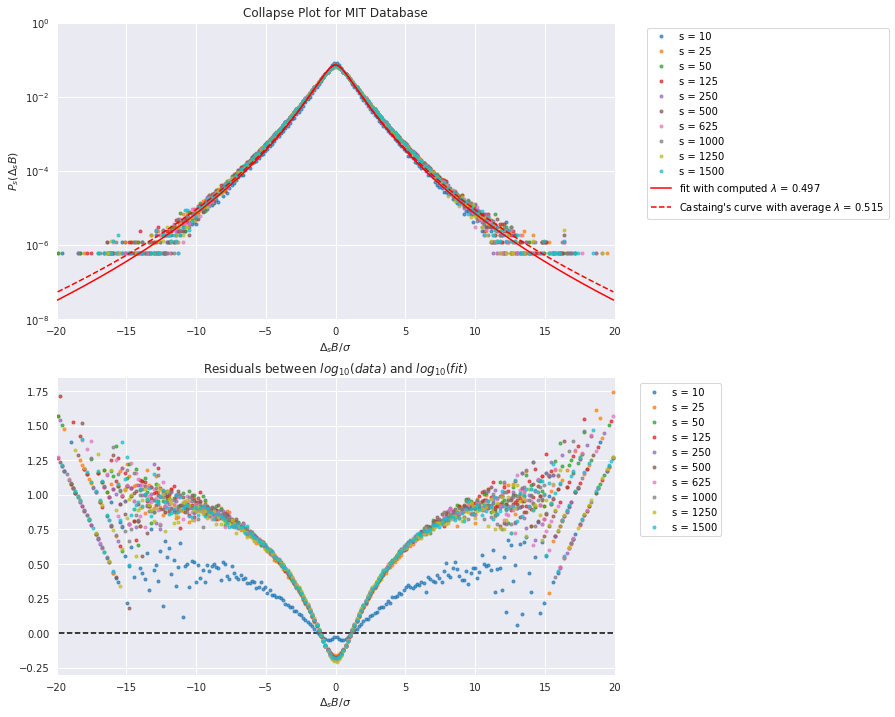

In [28]:
# Histograms' parameters
n_bins = 250
hist_range = 20
marker_size = 3
# All values of histograms.
histo_tot = np.zeros(n_bins)

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Collapse Plot for MIT Database")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1)
ax[0].set_xlim([-hist_range,hist_range])

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_xlim([-hist_range,hist_range])
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Generate histogram data and plot data points
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_mit.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2

    histo_tot += histo
    
    histo_fit_norm = histo/(np.sum(histo))
 
    # Plot data
    ax[0].plot(bins_centers, histo_fit_norm, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Fit
def C_log(x, lambd):
    c = Castaing_integral(x, lambd)
    return np.log10(c / (np.sum(c)))
histo_tot_norm = histo_tot / np.sum(histo_tot)
indices = histo_tot_norm != 0
histo_log = np.log10(histo_tot_norm[indices])

pars, pcov = curve_fit(f=C_log, 
                       xdata=bins_centers[indices], 
                       ydata=histo_log, 
                       p0=0.4, bounds=[0.1,1])

print(f"Best pars: {pars}, Covariance matrix: {pcov}")
std = np.sqrt(pcov[0,0])
# Plot Fit
y_fit = Castaing_integral(bins_centers, *pars) 
y_fit = y_fit / (np.sum(y_fit))
ax[0].plot(bins_centers, y_fit, color=color_fit, label=f"fit with computed $\lambda$ = {pars[0]:.3f}")
# Plot Castaing's curve with lambda = average
lambda_mean_mit = lambdas_mit.mean()
y_fit_mean = Castaing_integral(bins_centers, lambda_mean_mit)
y_fit_mean = y_fit_mean / np.sum(y_fit_mean)
ax[0].plot(bins_centers, y_fit_mean, "--", color=color_fit, 
           label=f"Castaing's curve with average $\lambda$ = {lambda_mean_mit:.3f}")

# Generate histogram data and plot residuals
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_mit.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    y = y*y.std()
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    histo_fit_norm = histo/(np.sum(histo))
    
    # Plot data
    y_fit_res = Castaing_integral(bins_centers, *pars) 
    y_fit_res = y_fit_res / (np.sum(y_fit_res))
    i_hist, i_fit = histo_fit_norm != 0, y_fit_res != 0
    indices = i_hist & i_fit
    residuals_log10 = np.log10(histo_fit_norm[indices])-np.log10(y_fit_res[indices])
    ax[1].plot(bins_centers[indices], residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Plot legends
ax[0].legend(bbox_to_anchor=legend_bbox_fit)
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

# Comparing the two lambdas
lambda_mean_err_mit = 1/np.sqrt(np.sum(1/lambdas_err_mit**2))
print(f"lambda's value from averaging previous list: {lambda_mean_mit:.4f}±{lambda_mean_err_mit:.4f}")
print(f"lambda's value from fit: {pars[0]:.4f}±{std:.4f}")

# Compatibility of lambda_fit and lambda_mean
m = lambda_mean_mit - pars[0]
# Var[m] = 1/N * (Var[l_mit] + Var[l_fit])
m_var = (lambda_mean_err_mit**2 + std**2) / bins_centers.shape[0]
m_err = np.sqrt(m_var)
# Standard variable
Z = m / m_err
print(f"Standard variable: {Z:.2f}")
# Level of significance
alpha = 0.05 # => confidence level = 95%
print(f"Level of confidence: {alpha}")
print("We try a two-tailed test")
# Critical value for two-tailed test
Z_alpha_half = 1.96
# Confidence interval
confid = (-Z_alpha_half, Z_alpha_half)
print(f"Confidence interval: [{confid[0]:.2f}, {confid[1]:.2f}]")
if confid[0] <= Z <= confid[1]:
    print("We can accept the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")
else:
    print("We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")

# Multifractality <a name="fractal"></a>

Representative examples of the increment series at different coarse-grained levels are shown. It is important to note that we cannot see significant differences between the plots: this is one of the characteristics of fractal systems.

In [30]:
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines,color1,color2, prop_patches=None):
    #default patches
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }
    #Connect two bboxes with a straight line.
    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False) #this allow me to see the line if it goes over a line
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)
    #Patch showing the shape bounded by a Bbox.
    bbox_patch1 = BboxPatch(bbox1, **prop_patches,color=color1)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches,color=color2)

    
    '''
    Connect two bboxes with a quadrilateral.

    The quadrilateral is specified by two lines that start and end at corners of the bboxes.
    The four sides of the quadrilateral are defined by the two lines given,
    the line between the two corners specified in bbox1 and the line between the two corners specified in bbox2.
    '''    
    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax,color1="red",color2="yellow", **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """
    #define the factory object (it will then define the real object we wonna create)
    #transData and Axes allow me to modify The coordinate system for the data, controlled by xlim 
    #and ylim and The coordinate system of the Axes; 
    #(0, 0) is bottom left of the axes, and (1, 1) is top right of the axes.
    
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes )
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    
    
    #Create a new object Bbox from *left*, *bottom*,*right* and *top*.
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    #transform the bbox with the transformatio trans1-2
    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    #alpha is the transparency of the patch
    #ec is the edge color, **kwargs of course is the possible others parameters of the patch
    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs,color1=color1,color2=color2, prop_patches=prop_patches)
    '''
    'upper right'  : 1,
    'upper left'   : 2,
    'lower left'   : 3,
    'lower right'  : 4

    '''
    #Add the Patches to the axes' patches
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

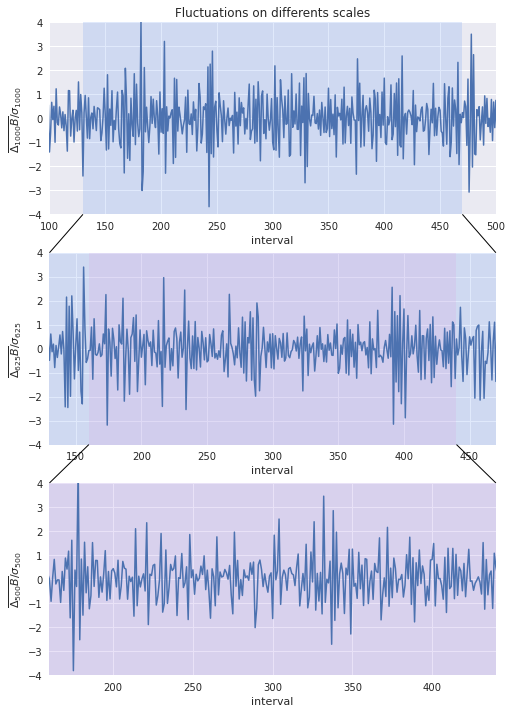

In [32]:
def plotB(df,s,ranges,increment=600):
    #example of use : plotB(df,10,100,250)
    '''
    df: dataframe of the data
    s: list of 3 scale parameter
    ranges: list of range of the zoom 
    '''
    with plt.style.context("seaborn"):
        fig, ax = plt.subplots(3,1, figsize=(8,12))
    #delete nan from dataframe and plot 
    
    ax[0].set_title("Fluctuations on differents scales")
    ax[0].set_xlabel("interval")
    ax[0].set_ylabel(r"$\overline{\Delta_{"+str(s[0])+"} B} / \sigma_{"+str(s[0])+"}$")
    ax[0].set_ylim(-4, 4)

    ax[1].set_ylabel(r"$\overline{\Delta_{"+str(s[1])+"} B} / \sigma_{"+str(s[1])+"}$")
    ax[1].set_xlabel("interval")
    ax[1].set_ylim(-4, 4)

    ax[2].set_ylabel(r"$\overline{\Delta_{"+str(s[2])+"} B} / \sigma_{"+str(s[2])+"}$")
    ax[2].set_xlabel("interval")
    ax[2].set_ylim(-4, 4)
    
    for j,k in enumerate(s) :
        y= df.loc[k]
        y=y[y.isna()== False] 
        
        c=int(len(y)/(2*k))
        y_plot=np.zeros(c)
        for i in range(c):    
            y_plot[i]=np.mean(y[i*2*k:(i+1)*2*k])
        
        ax[j].plot(y_plot/(np.std(y_plot)))
        ax[j].set_xlim(ranges[0]+j*increment,ranges[1]-j*increment)      
    
    zoom_effect01(ax[0], ax[1], ranges[0]+increment, ranges[1]-increment, color1 = 'cornflowerblue', color2 = "cornflowerblue")
    zoom_effect01(ax[1], ax[2], ranges[0]+2*increment, ranges[1]-2*increment, color1 = 'plum', color2 = "mediumpurple")

s_list = np.array([10,25,50,125,250,500,625,1000,1250,1500])        
plotB(df_mit,[1000,625,500],[100, 500], increment=30)      

$\overline{\Delta_s B(i)} = \frac{1}{2s} \Sigma_{j=i(2s)}^{(i+1)s} \Delta_s B(i)$

## Calculation of Hurst coefficient <a name="hurst"></a>

One of the methods to characterize fractal signals with long-range power-law correlations and multiscaling properties is a scaling analysis of the $qth$-order partition function [7]:


\begin{equation}
Z_{q}(s)=<|B(i+s)-B(i)|^q> 
\end{equation}

For self-affine function there exist an infinite hierarchy of exponent $H_{q}$ describing the scaling of $ Z_{q}(s)\sim s^{qH_{q}}$ [5].


The studies on those scaling exponents in the interbeat dynamic can be used to discriminate between healthy and pathological data [6].


Conventionally, the mean square displacement $Z_{2}(s)$
is related to the so called Hurst exponents as $Z_{2}(s) \sim s^{2H}$. Calculating H we can discriminize different case :

* $H = 0.5$ the increment of the $B(i)$ is uncorrelated and the signal $b(i)$ is white noise;
* $H<0.5$ the signal is anti-correlated;
* $H>0.5$ the signal is correlated;

The particular cases with $H=1$ corresponds to $1/f$ noise, typical of human heart rate. 


 Analyzing  40 ECG, the mean value of the H coefficient is : 1.0006 ± 0.00001


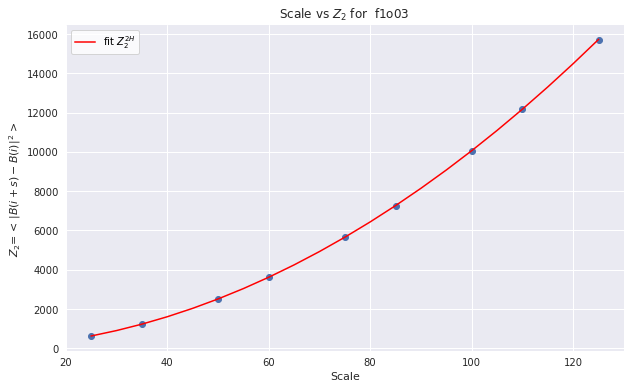

In [40]:
def Hurst_fit(s,H,q=2):
    return s**(q*H)

def Zq_calculation(names,s_list,q=2, plot=True):
    '''
    names: list of ID of the ECG
    s_list : list of scales 
    q: the function calculates Z_{q}: q-th order of the partition function    
    plot=True: plot an example of fit estimation
    '''
    h_list=[]
    var_list=[]
    for nome in (names):
        b_i=fantasia_ds.b_i_from_name(nome) #take b(i) 
        B2=np.cumsum(b_i)       #"integrate" it
        Zq=np.zeros(len(s_list) )
        
        for j,k in enumerate(s_list):   #given a scale it evaluate the statistical mean of |B[i+s]-B[i]|^q
            dummyZq=[]  
         
            for u in range(len(B2) - k ):
                 dummyZq.append(np.power( np.absolute(B2[u+k]-B2[u]),q) )# 
            Zq[j]=np.mean(dummyZq)
            
        pars, pcov = curve_fit(f=Hurst_fit, xdata=(s_list), ydata=(Zq), p0=1.) #calculate H with error
        
        if plot==True and nome==names[2]:
            with plt.style.context("seaborn"):
                fig, ax = plt.subplots(1,1, figsize=(10,6))
            ax.plot(s_list,Zq,'o' )
            ax.set_title("Scale vs $Z_{"+str(q)+"}$ for  "+ str(nome)+" ")
            ax.set_ylabel(r"$Z_{"+str(q)+"} \equal$ < $ |B(i+s)-B(i)|^{"+str(q)+"}$ > ")
            ax.set_xlabel("Scale")
            s_range=np.arange(s_list[0],s_list[-1]+1,5)
            ax.plot(s_range,Hurst_fit(s_range,pars[0]),color='r',label="fit $Z_{"+str(q)+"}^{"+str(q)+"H}$")
            ax.legend()
            
            
        h_list.append(pars[0])
        var_list.append(1/pcov[0,0])
    meanH=np.dot(var_list,h_list)/np.sum(var_list) # weight mean and weight mean err
    
    errorH=np.sqrt(1/np.sum(var_list)) 
    return meanH, errorH

    
    
mean,error = Zq_calculation(fantasia_ds.names,[25,35,50,60,75,85,100,110,125])
print(" Analyzing ",len(fantasia_ds.names),"ECG, the mean value of the H coefficient is :", 
      round(mean,5),u"\u00B1", f"{round(error,5):.5f}" )


# An alternative way to fit the data could be, how it is done in the paper, 
# using linearization ( plot log(rad(Z)) vs log(s))

# Short analysis of a non-healthy patients' dataset <a name="analysis_3"></a>

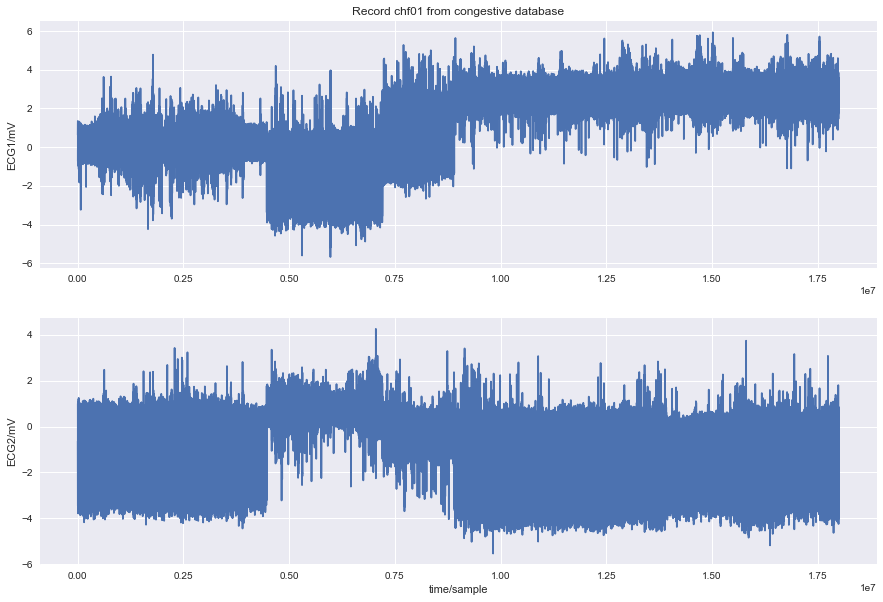

{'record_name': 'chf01', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 17994491, 'base_time': datetime.time(10, 0), 'base_date': None, 'comments': ['Age: 71  Sex: M  NYHA class: III-IV'], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[ 0.635, -0.64 ],
       [ 0.68 , -1.28 ],
       [ 0.63 , -1.92 ],
       ..., 
       [ 2.265, -0.52 ],
       [ 2.245, -0.5  ],
       [ 2.245, -0.515]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['chf01.dat', 'chf01.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [127, -128], 'checksum': [17579, 21162], 'block_size': [0, 0]}


In [34]:
congestive_ds = Dataset("congestive")
congestive_ds.path = "./bidmc-congestive-heart-failure-database-1.0.0/files/"
congestive_ds.names = ['chf01', 'chf02', 'chf03', 'chf04', 'chf05', 'chf06', 'chf07', 
                       'chf08', 'chf09', 'chf10', 'chf11', 'chf12', 'chf13', 'chf14', 'chf15']
congestive_ds.rec0 = wfdb.rdrecord(congestive_ds.path + congestive_ds.names[0])
congestive_ds.channel = 0

df_congestive = congestive_ds.load_df()

congestive_ds.plot_rec0_info()

### Plotting interbeat intervals $b$ before and after cleaning up <a name="plot_b_i_3"></a>

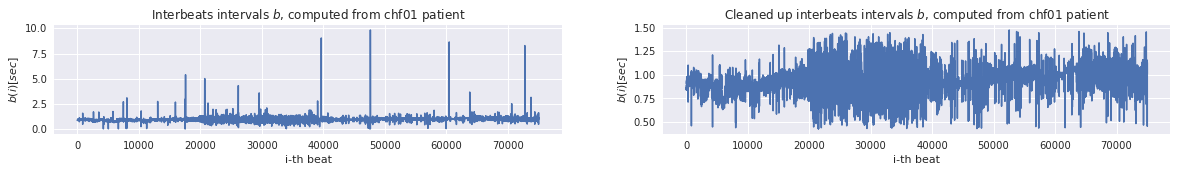

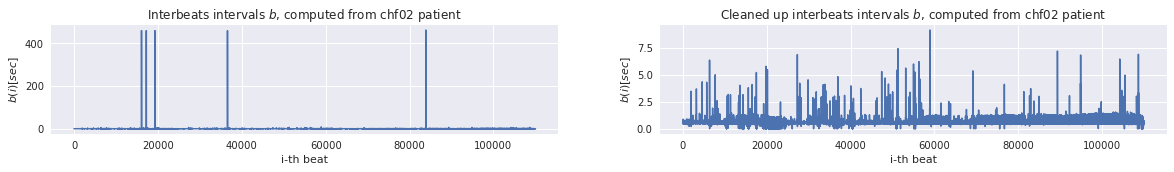

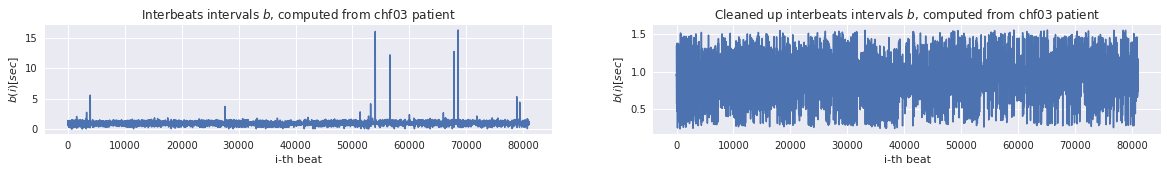

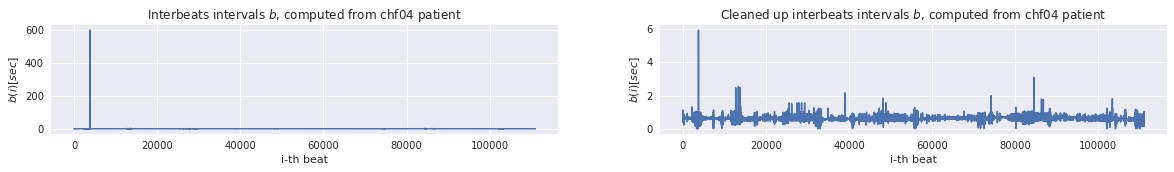

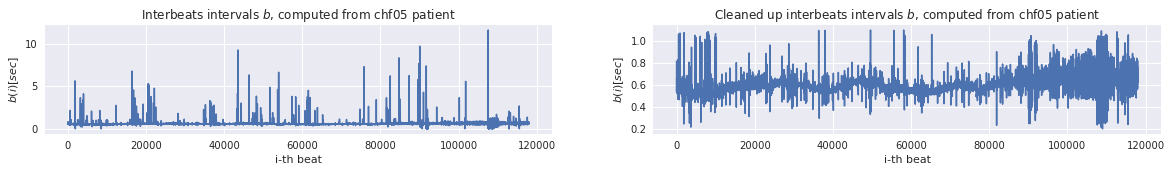

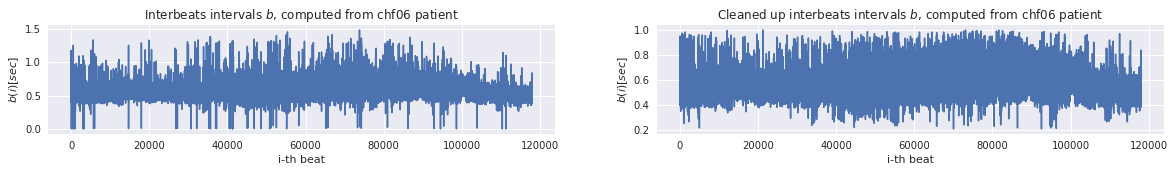

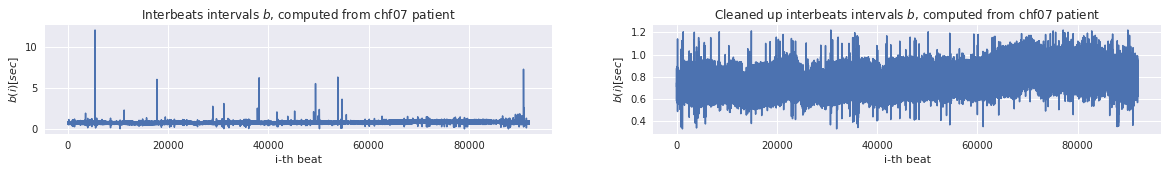

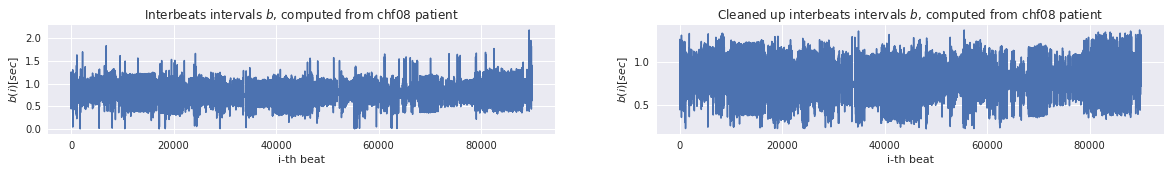

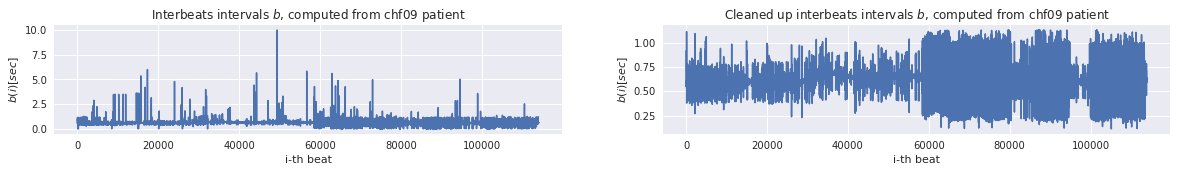

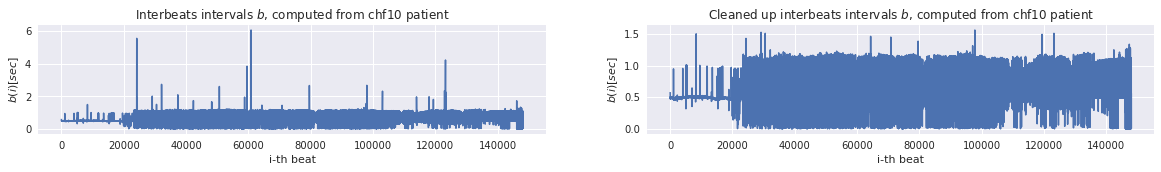

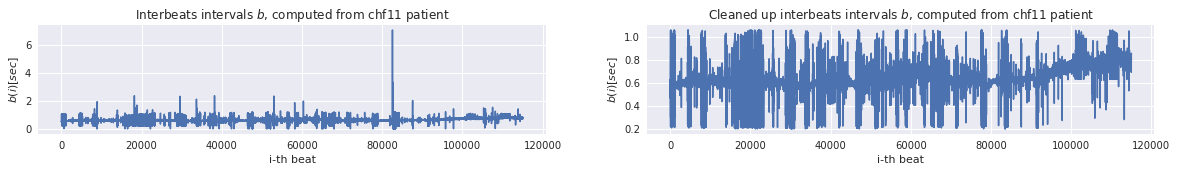

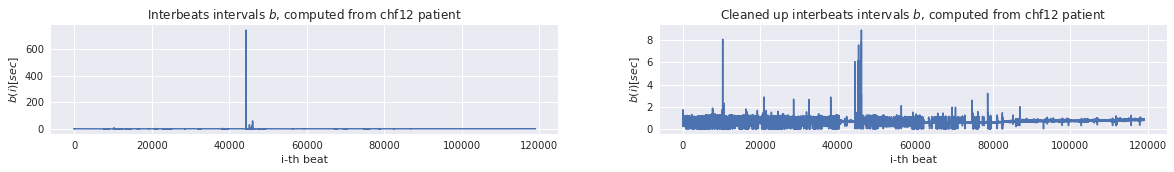

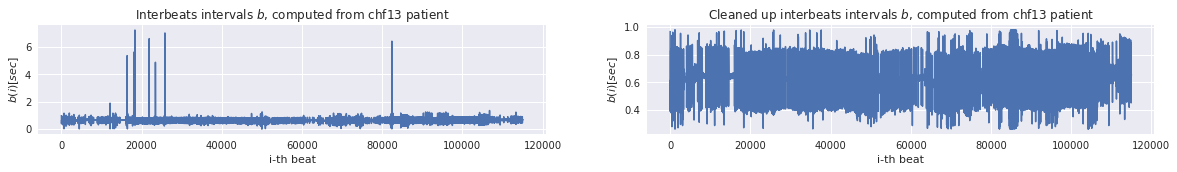

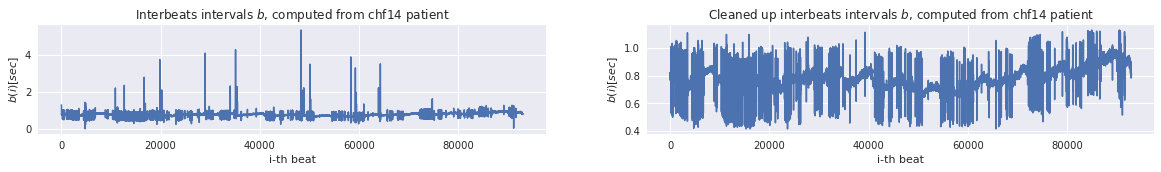

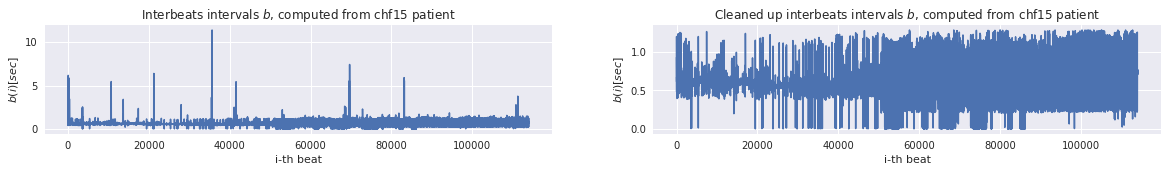

In [35]:
congestive_ds.plot_all_b_i()

### Gaussian fit <a name="gauss_3"></a>

100%|██████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]

R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.
RMSE and NRMSE values are in agreement with R2 values


$R^2$      RMSE     NRMSE
s                                  
10   -10.739037  3.272737  0.816354
25    -8.812606  2.987217  0.681275
50    -8.878190  3.021841  0.644338
125   -8.939167  3.022061  0.594508
250   -8.654405  3.010739  0.558489
500   -8.520991  3.005571  0.527953
625   -8.455764  3.001070  0.518361
1000  -8.319697  2.994379  0.499472
1250  -8.266257  2.997638  0.491977
1500  -8.435751  3.007956  0.487656

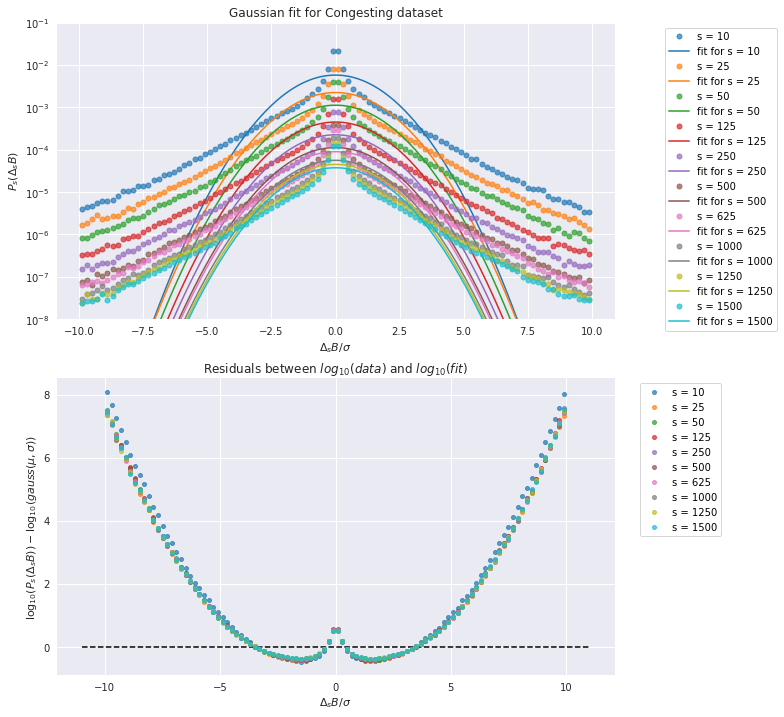

In [36]:
# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Gaussian fit for Congesting dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(gauss" + "(\mu, \sigma))$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].hlines(0, -11, 11, linestyles="dashed", colors="k")

# Output table
table = {"s":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_congestive.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y=y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=100, range=(-10, 10))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete emty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    mu, sigma = norm.fit(y)

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=5, alpha=0.7, label=f"s = {s}")
    # Plot Fit
    y_fit = norm.pdf(bins_c_fit, mu, sigma)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot Residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=4, alpha=0.7, label=f"s = {s}")
    
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("R2 values are all negatives, we therefore consider gaussian function a really bad approximation of data.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

### Castaing fit <a name="castaing_3"></a>

100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

We consider R2 scores good enough for Castaing fit.
RMSE and NRMSE values are in agreement with R2 values


$\lambda$  $\sigma_{\lambda}$     $R^2$      RMSE     NRMSE
s                                                                
10     0.626231            0.003028  0.986361  0.139914  0.029352
25     0.643792            0.002707  0.989880  0.117458  0.022948
50     0.630604            0.002534  0.990741  0.115274  0.021164
125    0.628662            0.002622  0.990053  0.120113  0.020540
250    0.623046            0.002464  0.991060  0.115200  0.018701
500    0.621697            0.002124  0.993315  0.099766  0.015433
625    0.612131            0.002285  0.992051  0.111163  0.016891
1000   0.610181            0.002417  0.991067  0.118430  0.017444
1250   0.606024            0.002500  0.990332  0.124384  0.018039
1500   0.609016            0.002248  0.992330  0.109763  0.015775

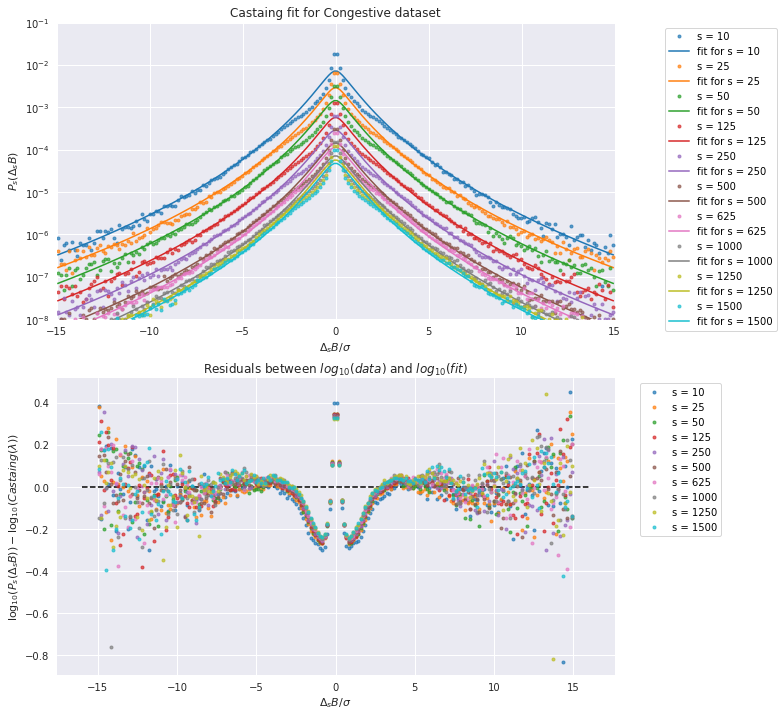

In [37]:
# Histograms' parameters
n_bins = 200
hist_range = 15
delta_bins = int(n_bins // 2)
marker_size = 3

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Castaing fit for Congestive dataset")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)
ax[0].set_xlim(-hist_range, hist_range)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_ylabel("$\log_{10}(P_s (\Delta_s B)) - \log_{10}" + "(Castaing" + "(\lambda))$")
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Saving lambdas' values and errors for later
lambdas_congestive = np.zeros(s_list.shape)
lambdas_err_congestive = np.zeros(s_list.shape)

# Output table
table = {"s":[], "$\lambda$":[], "$\sigma_{\lambda}$":[], "$R^2$":[], "RMSE":[], "NRMSE":[]}

for j in tqdm(range(len(s_list))):
    s = s_list[j]
    # Load PDF from dataframe
    y = df_congestive.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # Delete emty bins
    bins_index_fit=[]
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit=bins_centers[bins_index_fit]
    histo_fit=histo[bins_index_fit]
    
    # Fit data
    def C_log10(x, lambd):
        c = Castaing_integral(x, lambd)
        return np.log10(c / (s*np.sum(c)))
    
    histo_log = np.log10(histo_fit / (s*np.sum(histo_fit)))
    pars, pcov = curve_fit(f=C_log10, 
                           xdata=bins_c_fit[n_bins//2-delta_bins:n_bins//2+delta_bins], 
                           ydata=histo_log[n_bins//2-delta_bins:n_bins//2+delta_bins],
                           p0=0.4, bounds=[0.1,1])
    std = np.sqrt(pcov[0,0])
    # Save lambda and lambda_err
    lambdas_congestive[j] = pars[0]
    lambdas_err_congestive[j] = std

    # Plot data
    histo_plot = histo_fit/(s*np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
    # Plot Fit
    y_fit = Castaing_integral(bins_c_fit, *pars)
    y_fit = y_fit / (s*np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")
    # Plot Residuals
    residuals_log10 = np.log10(histo_plot)-np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")
        
    # Print R2 score
    R2 = R2_score(histo_plot, y_fit)
    RMSE, NRMSE = RMSE_NRMSE(histo_plot, y_fit)
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)
    table["$\lambda$"].append(pars[0])
    table["$\sigma_{\lambda}$"].append(std)
    
ax[0].legend(bbox_to_anchor=(0,0,1.3,1))
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

print("We consider R2 scores good enough for Castaing fit.")
print("RMSE and NRMSE values are in agreement with R2 values")

table = pd.DataFrame(table)
# Substitute indices with s value
table.set_index('s', inplace=True)
table

### Collapse plot <a name="collapse_3"></a>

Best pars: [ 0.64486668], Covariance matrix: [[  3.08000812e-06]]
lambda's value from averaging previous list: 0.6211±0.0008
lambda's value from fit: 0.6449±0.0018
Standard variable: -195.45
Level of confidence: 0.05
We try a two-tailed test
Confidence interval: [-1.96, 1.96]
We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors


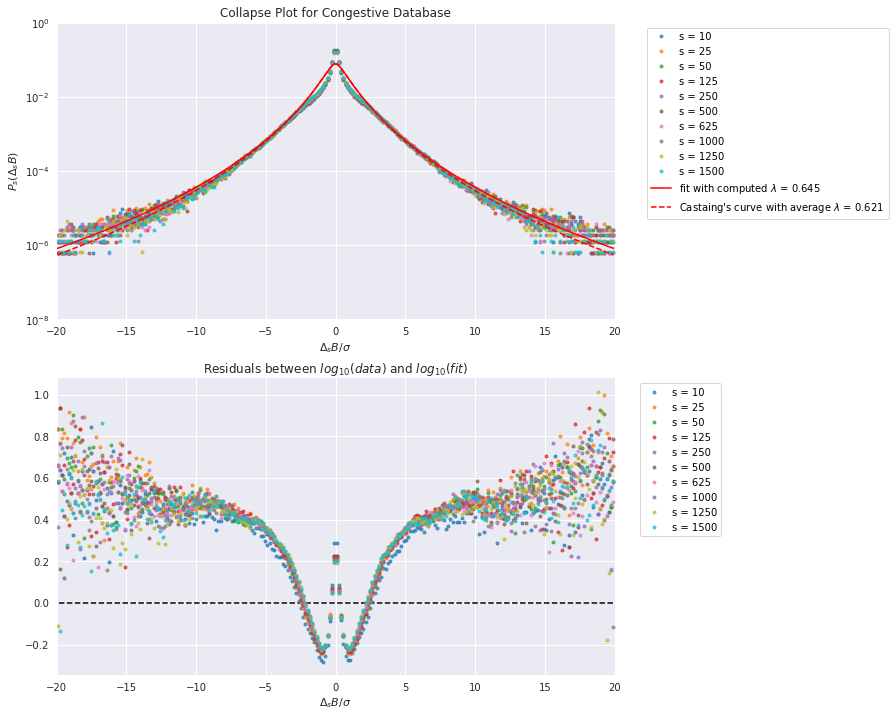

In [38]:
# Histograms' parameters
n_bins = 250
hist_range = 20
marker_size = 3
# All values of histograms.
histo_tot = np.zeros(n_bins)

# Create figure and add axes object
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(2,1, figsize=figsize_2_rows)
ax[0].set_title("Collapse Plot for Congestive Database")
ax[0].set_xlabel("$\Delta_s B / \sigma$")
ax[0].set_ylabel("$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1)
ax[0].set_xlim([-hist_range,hist_range])

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel("$\Delta_s B / \sigma$")
ax[1].set_xlim([-hist_range,hist_range])
ax[1].hlines(0, -hist_range-1, hist_range+1, linestyles="dashed", colors="k")

# Generate histogram data and plot data points
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_congestive.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2

    histo_tot += histo
    
    histo_fit_norm = histo/(np.sum(histo))
 
    # Plot data
    ax[0].plot(bins_centers, histo_fit_norm, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Fit
def C_log(x, lambd):
    c = Castaing_integral(x, lambd)
    return np.log10(c / (np.sum(c)))
histo_tot_norm = histo_tot / np.sum(histo_tot)
indices = histo_tot_norm != 0
histo_log = np.log10(histo_tot_norm[indices])

pars, pcov = curve_fit(f=C_log, 
                       xdata=bins_centers[indices], 
                       ydata=histo_log, 
                       p0=0.4, bounds=[0.1,1])
print(f"Best pars: {pars}, Covariance matrix: {pcov}")
std = np.sqrt(pcov[0,0])
# Plot Fit
y_fit = Castaing_integral(bins_centers, *pars) 
y_fit = y_fit / (np.sum(y_fit))
ax[0].plot(bins_centers, y_fit, color=color_fit, label=f"fit with computed $\lambda$ = {pars[0]:.3f}")
# Plot Castaing's curve with lambda = average
lambda_mean_congestive = lambdas_congestive.mean()
y_fit_mean = Castaing_integral(bins_centers, lambda_mean_congestive)
y_fit_mean = y_fit_mean / np.sum(y_fit_mean)
ax[0].plot(bins_centers, y_fit_mean, "--", color=color_fit, 
           label=f"Castaing's curve with average $\lambda$ = {lambda_mean_congestive:.3f}")

# Generate histogram data and plot residuals
for j, s in enumerate(s_list):
    # Load PDF from dataframe
    y = df_congestive.loc[s]
    # Delete NaNs using the mask y.isna()== False
    y = y[y.isna()== False]  
    y = y*y.std()
    
    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_number = len(histo)   
    # Find center of each bin
    bins_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    histo_fit_norm = histo/(np.sum(histo))
    
    # Plot data
    y_fit_res = Castaing_integral(bins_centers, *pars) 
    y_fit_res = y_fit_res / (np.sum(y_fit_res))
    i_hist, i_fit = histo_fit_norm != 0, y_fit_res != 0
    indices = i_hist & i_fit
    residuals_log10 = np.log10(histo_fit_norm[indices])-np.log10(y_fit_res[indices])
    ax[1].plot(bins_centers[indices], residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.7, label=f"s = {s}")

# Plot legends
ax[0].legend(bbox_to_anchor=legend_bbox_fit)
ax[1].legend(bbox_to_anchor=legend_bbox_residuals)

# Comparing the two lambdas
lambda_mean_err_congestive = 1/np.sqrt(np.sum(1/lambdas_err_congestive**2))
print(f"lambda's value from averaging previous list: {lambda_mean_congestive:.4f}±{lambda_mean_err_congestive:.4f}")
print(f"lambda's value from fit: {pars[0]:.4f}±{std:.4f}")

# Compatibility of lambda_fit and lambda_mean
m = lambda_mean_congestive - pars[0]
# Var[m] = 1/N * (Var[l_congestive] + Var[l_fit])
m_var = (lambda_mean_err_congestive**2 + std**2) / bins_centers.shape[0]
m_err = np.sqrt(m_var)
# Standard variable
Z = m / m_err
print(f"Standard variable: {Z:.2f}")
# Level of significance
alpha = 0.05 # => confidence level = 95%
print(f"Level of confidence: {alpha}")
print("We try a two-tailed test")
# Critical value for two-tailed test
Z_alpha_half = 1.96
# Confidence interval
confid = (-Z_alpha_half, Z_alpha_half)
print(f"Confidence interval: [{confid[0]:.2f}, {confid[1]:.2f}]")
if confid[0] <= Z <= confid[1]:
    print("We can accept the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")
else:
    print("We discard the hypotesis that differences between lambda_fit and lambda_mean are given by random factors")

# Conclusion <a name="conclusion"></a>
We have showed that detrended healthy human heart rate increments are not Gaussian distributed, but they display fat tails. Moreover, we have demonstrated the robust scale-invariance in the probability density function of such increments by means of the collapse plot: when the PDF’s at different scales are superimposed, all the data collapse on the same curve, which is one of the characteristic features observed in fluctuations at a critical point. <br>
The range of scales where this scale invariance of PDF is observed, spanning from about twenty beats to a few thousand heartbeats, is compatible with that of the robust, behavioral-independent 1/f scaling and multifractality of heart rate, that we also demonstrated by means of the Husrt coefficient analysis. <br>
This scale-independent and fractal structure supports the view that a healthy human heart rate is controlled to converge continually to a critical state and this is valid not only when going through a constant routine protocol, but also during normal daily life activities, where behavioral modifiers of heart rate dramatically change the mean level of heart rate. <br>
Studies on transport properties through complex networks have demonstrated maximum efficiency of transportation at the critical point, which is the phase transition point from an ‘‘uncrowded’’ state to a ‘‘congested’’ state in the transportation routes. Thus, our results may indicate that the central neuroregulation continually brings the heart to a critical state to maximize its functional ability. This may be particularly important in understanding the widely reported evidence that decreased 1=f variability is associated with increased mortality in cardiac patients. <br>
To date there have been no successful attempts to provide a satisfactory explanation for this.

# Bibliography  <a name="biblio"></a>


[1] Ken Kiyono et al., Educational Physiology Laboratory,"Critical scale invariance in a healthy human heart rate", 2004

[2] https://physionet.org/content/fantasia/1.0.0/ , last visit on 18/01/2020

[3] https://physionet.org/content/nsrdb/1.0.0/ , last visit on 18/01/2020

[4] https://physionet.org/content/chfdb/1.0.0/ , last visit on 18/01/2020


[5] A.L. Barabási and T. Vicsek,“Multifractality of self-affine fractals,”Phys. Rev. A, vol. 44, pp. 2730–2733, 1991.

[6] Rodriguez, E., Echeverria, J. C., & Alvarez-Ramirez, J. (2007). "Detrended fluctuation analysis of heart intrabeat dynamics." doi:10.1016/j.physa.2007.05.022

[7] Ken Kiyono et al., Educational Physiology Laboratory,"Multiscale Probability Density Function Analysis:Non-Gaussian and Scale-Invariant Fluctuations of Healthy Human Heart Rate", 2004

[8] B. Castaing, Y. Gagne and E.J. Hopfinger, "Velocity probability density functions of high Reynolds number turbulence"